# Tiempo de ejecución ≈ 20 - 25 min

# 0.- Importación de librerías y descarga del dataset : datos / imágenes

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

import numpy as np
import seaborn as sns
import cv2
import imageio.v3 as io

#Matplolib Settings
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')


#Librerías carga de imágenes
from tqdm import tqdm
from typing import Optional, Union

#División datos test y entrenamiento
from sklearn.model_selection import train_test_split

#Estadarización/Normalización
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#Tensorflow Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
import tensorflow_hub as hub

#Representación de modelos
from tensorflow.keras.utils import plot_model



#Combinación tipos de datos
from sklearn.svm import SVC

## Descarga dataset : datos e imágenes

In [2]:
#Descarga del dataset
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2023-09-10 15:02:54--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.249.199.226, 34.248.20.69
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [          <=>       ]  54.31M  3.13MB/s    in 18s     

2023-09-10 15:03:13 (3.06 MB/s) - ‘airbnb-listings.csv’ saved [56950929]



In [3]:
#Guardado csv en pandas dataframe
data = pd.read_csv("airbnb-listings.csv", sep = ';')

#Quitamos aquellas columnas donde el precio sea nulo
data = data.dropna(subset=['Price'])
data.head(5)

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,15459188,https://www.airbnb.com/rooms/15459188,20170407214050,2017-04-08,Paseo De Gracia I (433),"Unique apartment in vibrant neighborhoods, car...","Its high ceilings, wooden floors, large window...","Unique apartment in vibrant neighborhoods, car...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/ced19499-8...,https://a0.muscache.com/im/pictures/ced19499-8...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ced19499-8...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","Dreta de l'Eixample, Barcelona, Catalunya 0800...",Dreta de l'Eixample,la Dreta de l'Eixample,Eixample,Barcelona,Catalunya,08009,Barcelona,"Barcelona, Spain",ES,Spain,41.391616,2.168168,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,94.0,NaN,NaN,NaN,NaN,1,0,2,1125,2 weeks ago,NaN,0,0,0,0,2017-04-08,1,2017-01-22,2017-01-22,60.0,6.0,8.0,10.0,6.0,10.0,8.0,NaN,NaN,strict,92,0.39,"41.39161588920901,2.1681677061165425","Host Has Profile Pic,Host Identity Verified,Is..."
1,13184463,https://www.airbnb.com/rooms/13184463,20170407214050,2017-04-08,"Rooftop 2 terraces full of art, style and views","Our place is In the cross between Born, Barce...",The views above Barcelona are unique. The styl...,"Our place is In the cross between Born, Barce...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/6e41526e-e...,https://a0.muscache.com/im/pictures/6e41526e-e...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/6e41526e-e...,5143182,https://www.airbnb.com/users/show/5143182,Ana,2013-02-19,"Barcelona, Catalonia, Spain","De Madrid, viviendo en Barcelona. Viajera, cur...",within a day,90.0,NaN,https://a0.muscache.com/im/users/5143182/profi...,https://a0.muscache.com/im/users/5143182/profi...,El Gòtic,1.0,1.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.381369,2.180874,Apartment,Entire home/apt,3,1.5,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Smoking allowed,Pets...",NaN,115.0,NaN,NaN,NaN,20.0,2,20,1,30,4 weeks ago,NaN,0,0,0,98,2017-04-07,9,2016-07-11,2017-03-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,flexible,1,0.99,"41.38136867557121,2.1808743514708038","Host Has Profile Pic,Host Identity Verified,Is..."
2,17115175,https://www.airbnb.com/room

In [4]:
#Descarga de imágenes
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=np.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

### Ópción 1 : Descarga completa

Debido a las limitaciones de hardware y tiempo, limitaremos la descargas a un máximo de 2500 intentos de descarga.


In [5]:
images, idxs = download_images(data['Thumbnail Url'], max_imgs=2500)
images = images.astype("float32") / 255.

100%|██████████| 2500/2500 [09:22<00:00,  4.45it/s]


(1544, 224, 224, 3)

In [6]:
data = data.iloc[idxs]
data = data.reset_index(drop=True)
data.head(5)

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,15459188,https://www.airbnb.com/rooms/15459188,20170407214050,2017-04-08,Paseo De Gracia I (433),"Unique apartment in vibrant neighborhoods, car...","Its high ceilings, wooden floors, large window...","Unique apartment in vibrant neighborhoods, car...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/ced19499-8...,https://a0.muscache.com/im/pictures/ced19499-8...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ced19499-8...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","Dreta de l'Eixample, Barcelona, Catalunya 0800...",Dreta de l'Eixample,la Dreta de l'Eixample,Eixample,Barcelona,Catalunya,08009,Barcelona,"Barcelona, Spain",ES,Spain,41.391616,2.168168,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,94.0,NaN,NaN,NaN,NaN,1,0,2,1125,2 weeks ago,NaN,0,0,0,0,2017-04-08,1,2017-01-22,2017-01-22,60.0,6.0,8.0,10.0,6.0,10.0,8.0,NaN,NaN,strict,92,0.39,"41.39161588920901,2.1681677061165425","Host Has Profile Pic,Host Identity Verified,Is..."
1,13184463,https://www.airbnb.com/rooms/13184463,20170407214050,2017-04-08,"Rooftop 2 terraces full of art, style and views","Our place is In the cross between Born, Barce...",The views above Barcelona are unique. The styl...,"Our place is In the cross between Born, Barce...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/6e41526e-e...,https://a0.muscache.com/im/pictures/6e41526e-e...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/6e41526e-e...,5143182,https://www.airbnb.com/users/show/5143182,Ana,2013-02-19,"Barcelona, Catalonia, Spain","De Madrid, viviendo en Barcelona. Viajera, cur...",within a day,90.0,NaN,https://a0.muscache.com/im/users/5143182/profi...,https://a0.muscache.com/im/users/5143182/profi...,El Gòtic,1.0,1.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.381369,2.180874,Apartment,Entire home/apt,3,1.5,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Smoking allowed,Pets...",NaN,115.0,NaN,NaN,NaN,20.0,2,20,1,30,4 weeks ago,NaN,0,0,0,98,2017-04-07,9,2016-07-11,2017-03-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,flexible,1,0.99,"41.38136867557121,2.1808743514708038","Host Has Profile Pic,Host Identity Verified,Is..."
2,17115175,https://www.airbnb.com/room

In [137]:
images.shape , data.shape

((1544, 224, 224, 3), (1544, 89))

In [7]:
#Montamos Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [139]:
# Guardamos en Google Drive
np.save('images_airbnb.npy', images)
data.to_csv('data_airbnb.csv', sep=';', index=False)

In [140]:
#Cargamos los ficheros anteriormente guardados en Google Drive
!cp images_airbnb.npy /content/drive/MyDrive/images_airbnb.npy
!cp data_airbnb.csv /content/drive/MyDrive/data_airbnb.csv

# Comprobamos que se han guardado correctamente
!ls -lah images* data*

-rw-r--r-- 1 root root 6.1M Sep 10 15:23 data_airbnb.csv
-rw-r--r-- 1 root root 887M Sep 10 15:23 images_airbnb.npy


### Opción 2: Descarga de imágenes y datos desde Google Drive previamente descargados de la opción 1

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
data = pd.read_csv("/content/drive/MyDrive/data_airbnb.csv", sep=';')
images = np.load("/content/drive/MyDrive/images_airbnb.npy")
data.shape, images.shape

((1544, 89), (1544, 224, 224, 3))

 # 1.- División train / test

## Funciones Auxiliares

In [19]:
#Funcion para mostrar columnas por su tipo ( numéricas y no numéricas)
def tipo_columnas(df):
    """Información sobre columnas numéricas y no numéricas de un dataframe.

	Parámetros:
	df -- dataframe

	Returns:
	num --  array con columnas numéricas('int','float')
	not_num -- array con columnas no numéricas.
	"""
    columnas_numericas = df.select_dtypes(include=['int', 'float','uint8']).columns
    print(f"Columnas numéricas: {len(columnas_numericas)} columnas.")
    print(', '.join(columnas_numericas))
    # Obtener las columnas de tipo no numérico
    columnas_no_numericas = df.select_dtypes(exclude=['int', 'float','uint8']).columns
    print(f"Columnas no númericas: {len(columnas_no_numericas)} columnas.")
    print(', '.join(columnas_no_numericas))
    return columnas_numericas , columnas_no_numericas


In [20]:
col_num , col_not_num = tipo_columnas(data)

Columnas numéricas: 40 columnas.
ID, Scrape ID, Host ID, Host Response Rate, Host Acceptance Rate, Host Listings Count, Host Total Listings Count, Zipcode, Latitude, Longitude, Accommodates, Bathrooms, Bedrooms, Beds, Square Feet, Price, Weekly Price, Monthly Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights, Maximum Nights, Has Availability, Availability 30, Availability 60, Availability 90, Availability 365, Number of Reviews, Review Scores Rating, Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Location, Review Scores Value, Jurisdiction Names, Calculated host listings count, Reviews per Month
Columnas no númericas: 49 columnas.
Listing Url, Last Scraped, Name, Summary, Space, Description, Experiences Offered, Neighborhood Overview, Notes, Transit, Access, Interaction, House Rules, Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host URL, Host Name, Host Since, Host Locati

## División train/valid/test

Para adaptarnos en un entorno más realista, dividiremos los datos en train test y validación. Después de la división haremos el análisis exploratorio en el train y los cambios que hagamos en él se lo haremos también a validación y test.

In [21]:
from sklearn.model_selection import train_test_split

train, test   = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
test, valid   = train_test_split(test, test_size=0.5, shuffle=True, random_state=42)

print(f'Dimensiones dataset datos tabulares train: {train.shape}')
print(f'Dimensiones dataset datos tabulares valid: {valid.shape}')
print(f'Dimensiones dataset datos tabulares test:  {test.shape}')

Dimensiones dataset datos tabulares train: (1235, 89)
Dimensiones dataset datos tabulares valid: (155, 89)
Dimensiones dataset datos tabulares test:  (154, 89)


In [22]:
#Indices de las entradas correspondiente a train / valid / test realizado por la división
train_index , valid_index , test_index = train.index , valid.index , test.index

## Guardar datos en ficheros

In [23]:
# Guardamos datos tabulares train / validación / test  en ficheros
data.loc[train_index].to_csv('./train_airbnb.csv', sep=';', decimal='.', index=False)
data.loc[valid_index].to_csv('./valid_airbnb.csv', sep=';', decimal='.', index=False)
data.loc[test_index].to_csv('./test_airbnb.csv', sep=';', decimal='.', index=False)

In [24]:
print(f'Dimensiones dataset datos tabulares train fichero: {data.loc[train_index].shape}')
print(f'Dimensiones dataset datos tabulares valid fichero: {data.loc[valid_index].shape}')
print(f'Dimensiones dataset datos tabulares test  fichero:  {data.loc[test_index].shape}')

Dimensiones dataset datos tabulares train fichero: (1235, 89)
Dimensiones dataset datos tabulares valid fichero: (155, 89)
Dimensiones dataset datos tabulares test  fichero:  (154, 89)


In [25]:
#Guardamos imagenes train / validación / test  en ficheros
np.save('train_images_airbnb.npy',images[train_index])
np.save('valid_images_airbnb.npy',images[valid_index])
np.save( 'test_images_airbnb.npy',images[test_index])

In [26]:
print(f'Dimensiones dataset imagenes train: {images[train_index].shape}')
print(f'Dimensiones dataset imagenes valid: {images[valid_index].shape}')
print(f'Dimensiones dataset imagenes test:  {images[test_index].shape}')

Dimensiones dataset imagenes train: (1235, 224, 224, 3)
Dimensiones dataset imagenes valid: (155, 224, 224, 3)
Dimensiones dataset imagenes test:  (154, 224, 224, 3)


## Cargar ficheros de train para el preprocesamiento

In [27]:
data_train   = pd.read_csv("train_airbnb.csv", sep=';')
images_train = np.load("train_images_airbnb.npy")

In [28]:
data_train.shape, images_train.shape

((1235, 89), (1235, 224, 224, 3))

In [29]:
col_num , col_not_num = tipo_columnas(data_train)

Columnas numéricas: 40 columnas.
ID, Scrape ID, Host ID, Host Response Rate, Host Acceptance Rate, Host Listings Count, Host Total Listings Count, Zipcode, Latitude, Longitude, Accommodates, Bathrooms, Bedrooms, Beds, Square Feet, Price, Weekly Price, Monthly Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights, Maximum Nights, Has Availability, Availability 30, Availability 60, Availability 90, Availability 365, Number of Reviews, Review Scores Rating, Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Location, Review Scores Value, Jurisdiction Names, Calculated host listings count, Reviews per Month
Columnas no númericas: 49 columnas.
Listing Url, Last Scraped, Name, Summary, Space, Description, Experiences Offered, Neighborhood Overview, Notes, Transit, Access, Interaction, House Rules, Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host URL, Host Name, Host Since, Host Locati

Creamos un data train auxiliar para hacer el preprocesamiento que luego se realizará con todas las divisiones

In [30]:
data_train_aux = data_train.copy(deep=True)

# 2.- Análisis Exploratorio

## Datos tabulares

### Head

Se usa head traspuesto para ver algunos ejemplos de qué va cada columna:

In [31]:
data_train.head().T

,0,1,2,3,4
ID,231035,9360828,9087250,1162707,13025008
Listing Url,https://www.airbnb.com/rooms/231035,https://www.airbnb.com/rooms/9360828,https://www.airbnb.com/rooms/9087250,https://www.airbnb.com/rooms/1162707,https://www.airbnb.com/rooms/13025008
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,Exclusive Area Madrid City Center,Large apartment at Madrid centro,Cosy room near center of Madrid,NICE & BIG DOUBLE ROOM AT DOWNTOWN,Deluxe apartment for couples or business
Summary,Beautiful and spacious three bed apartment wit...,Large apartment located in the center of Madri...,Lovely and cosy room in apartment conviently l...,NaN,I have a whole apartment for you with double b...
Space,Our apartment is situated in Paseo de la Haban...,Una situación geográfica ideal en pleno centro...,"The apartment is recently renovated, really co...",We are a young couple; David (Spain) and Ana (...,I offer a complete apartment for you - you'll ...
Description,Beautiful and spacious three bed apartment wit...,Large apartment located in the center of Madri...,Lovely and cosy room in apartment conviently l...,We are a young couple; David (Spain) and Ana (...,I have a whole apartment for you with double b...
Experiences Offered,none,none,none,none,none
Neighborhood Overview,"Chamartin ""El Viso"" is an exclusive residentia...",Entre Gran Vía y la Puerta del Sol en una call...,NaN,NaN,Our area is calm and away from the noisy cente...


### Describe

Descripción de las variables numéricas

In [32]:
data_train.describe()

,ID,Scrape ID,Host ID,Host Response Rate,Host Acceptance Rate,Host Listings Count,Host Total Listings Count,Zipcode,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Jurisdiction Names,Calculated host listings count,Reviews per Month
count,1.235000e+03,1.235000e+03,1.235000e+03,1061.000000,0.0,1234.000000,1234.000000,1204.000000,1235.000000,1235.000000,1235.000000,1228.000000,1232.000000,1228.000000,51.000000,1235.000000,287.000000,285.000000,532.000000,696.000000,1235.000000,1235.000000,1235.000000,1235.000000,0.0,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,962.000000,962.000000,962.000000,959.000000,962.000000,959.000000,958.000000,0.0,1235.000000,976.000000
mean,1.065558e+07,2.017041e+13,3.833049e+07,95.632422,NaN,11.646677,11.646677,27149.378738,40.428141,-3.443804,3.110121,1.267508,1.327922,1.972313,315.843137,68.744130,373.024390,1466.210526,185.071429,29.383621,1.534413,6.951417,2.489879,833.569231,NaN,8.348988,21.691498,38.430769,200.232389,24.476923,91.944906,9.457380,9.386694,9.660063,9.661123,9.514077,9.277662,NaN,8.339271,2.014795
std,5.498928e+06,1.246013e+07,3.483452e+07,14.017598,NaN,33.484644,33.484644,4122.473785,0.184224,1.219156,1.974518,0.672776,0.880108,1.560269,498.453423,71.256693,201.366528,1694.680496,110.975959,23.027808,1.159587,8.924185,2.258179,474.716987,NaN,8.935234,19.247544,29.001046,128.185752,39.851345,8.123915,0.827941,0.936123,0.650341,0.676286,0.762892,0.862635,NaN,20.951531,1.943771
min,7.036400e+04,2.017032e+13,1.985400e+04,0.000000,NaN,0.000000,0.000000,2804.000000,39.473715,-3.785982,1.000000,0.000000,0.000000,1.000000,0.000000,10.000000,83.000000,270.000000,70.000000,4.000000,1.000000,0.000000,1.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,4.000000,4.000000,5.000000,2.000000,NaN,1.000000,0.020000
25%,6.304228e+06,2.017041e+13,7.860216e+06,100.000000,NaN,1.000000,1.000000,28005.000000,40.409424,-3.708108,2.000000,1.000000,1.000000,1.000000,0.000000,30.000000,206.000000,700.000000,100.000000,15.000000,1.000000,0.000000,1.000000,364.500000,NaN,0.000000,3.500000,10.000000,77.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,1.000000,0.540000
50%,1.189098e+07,2.017041e+13,2.871097e+07,100.000000,NaN,2.000000,2.000000,28012.000000,40.418770,-3.701067,2.000000,1.000000,1.000000,1.000000,40.000000,50.000000,350.000000,1200.000000,150.000000,25.000000,1.000000,0.000000,2.000000,1125.000000,NaN,6.000000,18.000000,36.000000,234.000000,7.000000,93.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,2.000000,1.350000
75%,1.549940e+07,2.017041e+13,5.751626e+07,100.000000,NaN,5.000000,5.000000,28017.000000,40.430000,-3.688976,4.000000,1.000000,2.000000,2.000000,511.000000,80.000000,499.000000,1750.000000,200.000000,35.000000,2.000000,12.000000,3.000000,1125.000000,NaN,13.000000,36.000000,62.000000,317.000000,30.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,4.000000,2.965000
max,1.810416e+07,2.017041e+13,1.246719e+08,100.000000,NaN,207.000000,207.000000,28850.000000,41.416297,3.273487,16.000000,8.000000,10.000000,16.000000,2153.000000,850.000000,950.000000,25000.000000,900.000000,260.000000,16.000000,70.000000,21.000000,2000.000000,NaN,30.000000,60.000000,90.000000,365.000000,343.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,145.000000,13.600000


### Dtypes

In [33]:
data_train.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
Summary                            object
Space                              object
Description                        object
Experiences Offered                object
Neighborhood Overview              object
Notes                              object
Transit                            object
Access                             object
Interaction                        object
House Rules                        object
Thumbnail Url                      object
Medium Url                         object
Picture Url                        object
XL Picture Url                     object
Host ID                             int64
Host URL                           object
Host Name                          object
Host Since                         object
Host Location                     

### Info

Información de las variables del dataframe

In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              1235 non-null   int64  
 1   Listing Url                     1235 non-null   object 
 2   Scrape ID                       1235 non-null   int64  
 3   Last Scraped                    1235 non-null   object 
 4   Name                            1235 non-null   object 
 5   Summary                         1190 non-null   object 
 6   Space                           913 non-null    object 
 7   Description                     1235 non-null   object 
 8   Experiences Offered             1235 non-null   object 
 9   Neighborhood Overview           754 non-null    object 
 10  Notes                           482 non-null    object 
 11  Transit                         741 non-null    object 
 12  Access                          69

## Imágenes

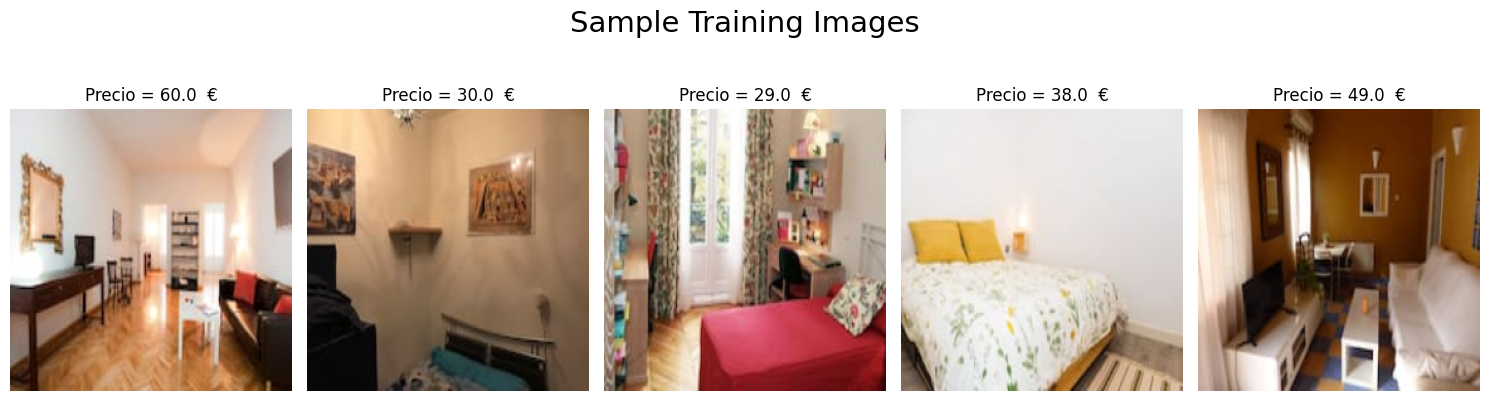

In [35]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
idx = np.random.randint(5, data_train.shape[0]-5)
for i, ax in enumerate(axes):
    if i < images_train.shape[0]:
        ax.imshow(images_train[idx])
        ax.set_title(f'Precio = {data_train["Price"][idx]}  €')
        ax.axis('off')
        idx += 1
    else:
        ax.axis('off')

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# 3.- Preprocesado

## A.- Eliminación de las variables

Se ve que gran parte de los datos no aportan información relevante. Se eliminarán las siguietnes columnas:

- ID
- Listing Url
- Scrape ID: no aporta información sobre la propiedad.
- Last Scraped: no aporta información sobre la propiedad.
- Thumbnail Url : ya hemos descargado las imagenes y guardado por lo que ya no es necesaria.
- Medium Url
- Picture Url
- XL Picture Url
- Host ID: aporta información sobre el dueño, pero no sobre la propiedad.
- Host Url
- Host Name: no aporta información sobre la propiedad.
- Host Thumbnail Url
- Host Picture Url
- Host Neighbourhood: no aporta información sobre la propiedad.
- Weekly Price: información redundante con Price
- Monthly Price: información redundante con Price
- Calendar Updated: información irrelevante; se podría inferir la frecuencia de actividad del dueño, pero YA hay un dato explícito de su tasa de respuesta.
- Calendar last Scraped: no aporta información sobre la propiedad.
- First review: no aporta información nueva; ya hay un dato de antiguedad del dueño.
- Last review: no aporta información nueva.
- Reviews per Month: no aporta información nueva
- Geolocation: es latitud + longitud y esos campos ya están en el dataset
- Host Listings Count, Host Total Listings Count, Calculated host listings count: contador relacionado con el dueño; no aporta información sobre la propiedad.

In [36]:
# Hacemos un drop de todas las columnas que OBVIAMENTE no aportan información relevante
not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url',
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name',
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price',
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review',
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]

data_train.drop(not_useful_columns, axis=1, inplace=True)

Existen otras columnas que parecen tener informacion que puede ser útil pero aún así considero suprimirlas. Las columnas son:



*   Name
*   Summary
*   Space
*   Description
*   Neighborhood Overview
*   Notes
*   Transit
*   Acces
*   Interaction
*   House Rules
*   Host Location
*   Host About







In [37]:
# Hacemos un drop de todas las columnas que aportando información quedan fuera del scope
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About'
]

data_train.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)

Se analiza el número de valores diferentes por columnas.

In [38]:
data_train.apply(lambda x: len(x.unique()))

Experiences Offered                1
Host Since                       802
Host Response Time                 5
Host Response Rate                35
Host Acceptance Rate               1
Host Verifications                83
Street                           314
Neighbourhood                     72
Neighbourhood Cleansed           137
Neighbourhood Group Cleansed      30
City                              19
State                             17
Zipcode                           90
Market                             5
Smart Location                    19
Country Code                       1
Country                            1
Latitude                        1235
Longitude                       1235
Property Type                     11
Room Type                          3
Accommodates                      13
Bathrooms                         16
Bedrooms                          10
Beds                              14
Bed Type                           5
Amenities                       1175
S

La columna Street no representa realmente la calle.

La variables City , State , Market , Smart Location , Country , Country Code , Neighbourhood y Zipcode indica información sobre la ubicación de la propiedad.
Por ello opto por quedarnos solo con la variable City y eliminar las demas variables debido que la mayoría de las observaciones pertenecen a Madrid ( posteriormente se observará)


In [39]:
data_train.drop(['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode'], axis=1, inplace=True)

Por último se comprueba qué variables tienen muchos valores missing (NaN or null). Hay columnas en las que apenas hay datos. No es conveniente imputar valores, ya que no hay una muestra significativa para extraer medias. Se hace drop de las columnas con muchos valores NaN.

In [40]:
print("Quitamos aquellas características que tiene un 80% o más de valores nulos\n\n")
print((data_train.isnull().sum().sort_values(ascending=False)/data_train.shape[0])*100)

Quitamos aquellas características que tiene un 80% o más de valores nulos


Host Acceptance Rate            100.000000
Jurisdiction Names              100.000000
Has Availability                100.000000
License                          98.380567
Square Feet                      95.870445
Security Deposit                 56.923077
Cleaning Fee                     43.643725
Neighbourhood                    33.684211
Review Scores Value              22.429150
Review Scores Checkin            22.348178
Review Scores Location           22.348178
Review Scores Rating             22.105263
Review Scores Accuracy           22.105263
Review Scores Cleanliness        22.105263
Review Scores Communication      22.105263
Host Response Rate               14.089069
Host Response Time               14.089069
Neighbourhood Group Cleansed      1.862348
Amenities                         1.538462
Bathrooms                         0.566802
Beds                              0.566802
Bedrooms             

In [41]:
print(f'El dataframe tiene un total de {len(data_train)} filas.')
len(data_train) - data_train.count() # vemos cuántos valores NaN hay por columna

El dataframe tiene un total de 1235 filas.


Experiences Offered                0
Host Since                         1
Host Response Time               174
Host Response Rate               174
Host Acceptance Rate            1235
Host Verifications                 0
Neighbourhood                    416
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed      23
City                               0
Country Code                       0
Latitude                           0
Longitude                          0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                          7
Bedrooms                           3
Beds                               7
Bed Type                           0
Amenities                         19
Square Feet                     1184
Price                              0
Security Deposit                 703
Cleaning Fee                     539
Guests Included                    0
Extra People                       0
M

In [42]:
columns_with_too_many_missing_values = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
]

data_train.drop(columns_with_too_many_missing_values, axis=1, inplace=True)

### Variables Redundantes

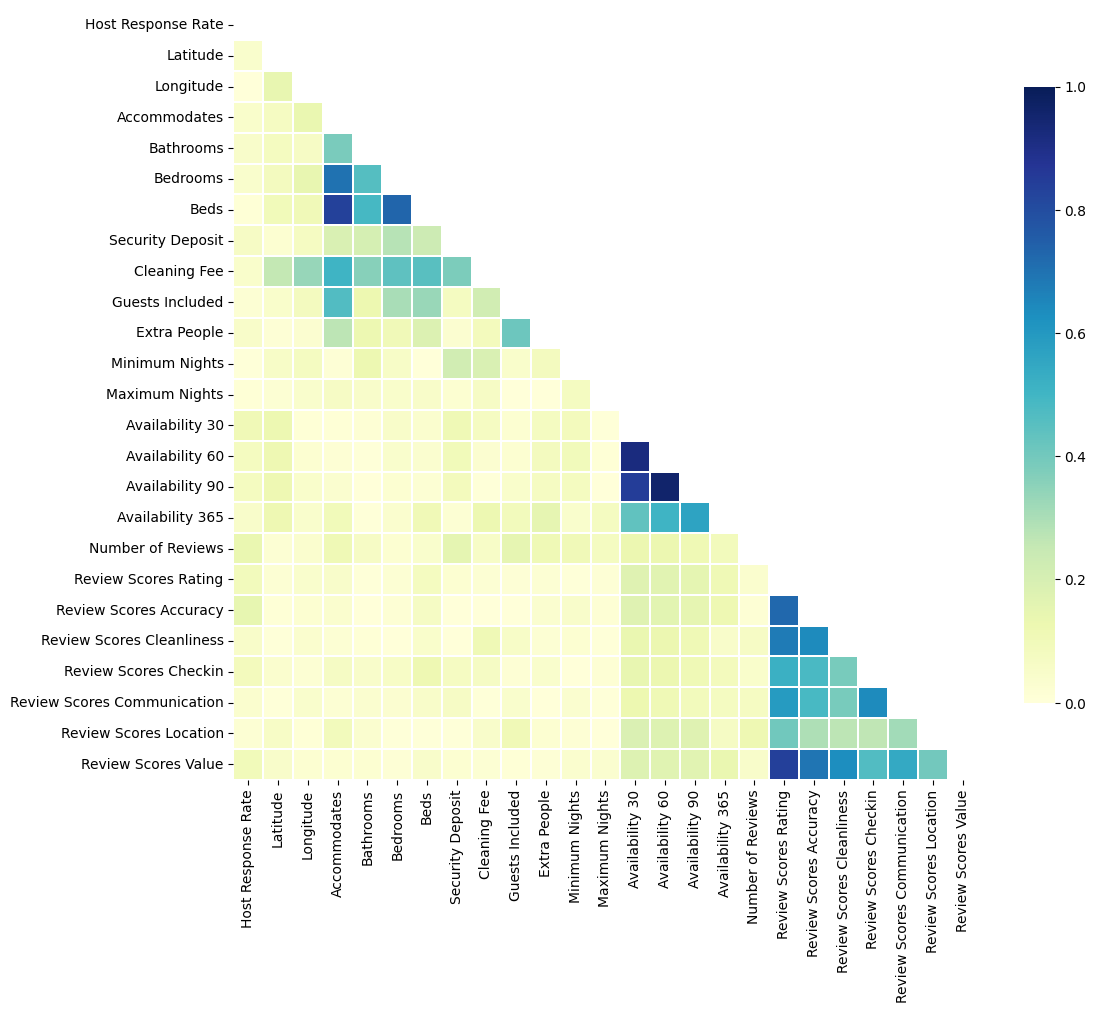

In [43]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data_train.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Hay alta correlacion entre las variables de availability y las de review.

Se eliminara todas las variables availability salvo 365 y se hace media de las review.

La variable Accomodates tiene alta correlación con Beds. Por lo cual, voy  a eliminar la variable Accomodates.



In [44]:
reviews = data_train.loc[: , "Review Scores Rating":"Review Scores Value"]
data_train['Average Review'] = reviews.mean(axis=1)

data_train.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating',
                 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
                 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
                 'Accommodates'], axis=1, inplace=True)

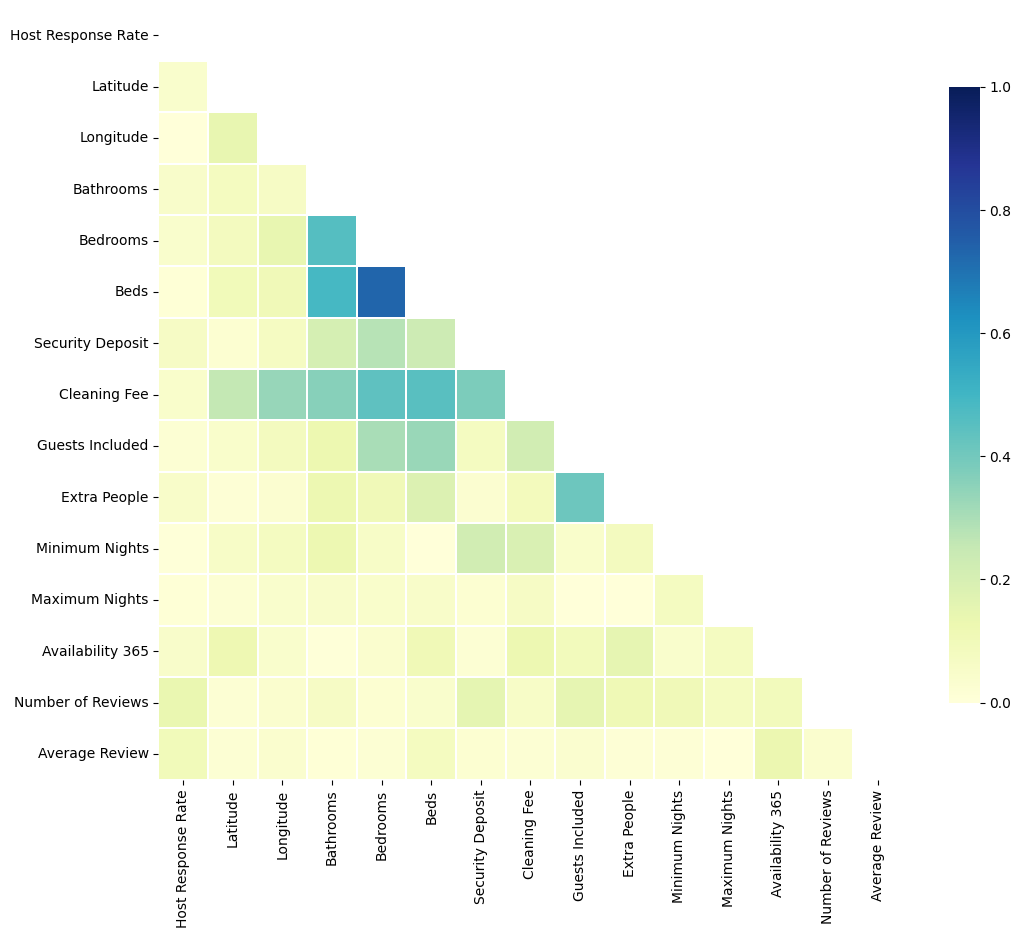

In [45]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data_train.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Se observa que no existe alta correlación entre variables.

### Outliers

##### Price

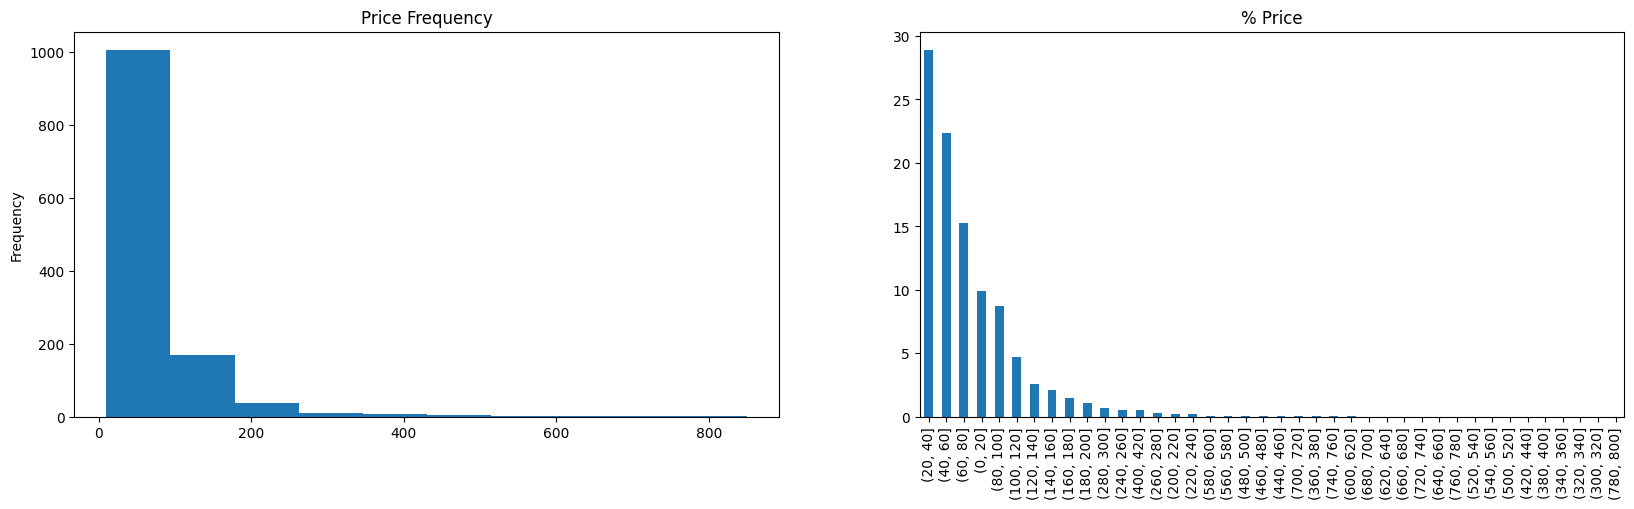

La mayoría de los precios oscilan entre 20 y 100 euros. Nos quedaremos con las entradas que tengan el precio en dicha orquilla


In [46]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
data_train['Price'].plot.hist(title='Price Frequency')
plt.subplot(1,2, 2)
(100 * pd.cut(data_train['Price'], bins=[x for x in range(0, 801, 20)]).value_counts() / len(data_train['Price'])).plot(kind='bar', title='% Price')
plt.show()
print("La mayoría de los precios oscilan entre 20 y 100 euros. Nos quedaremos con las entradas que tengan el precio en dicha orquilla")

In [47]:
#Price entre 20 y 120 €
data_train = data_train [(data_train['Price']>=20) & (data_train['Price']<=150)]

#### Property Type

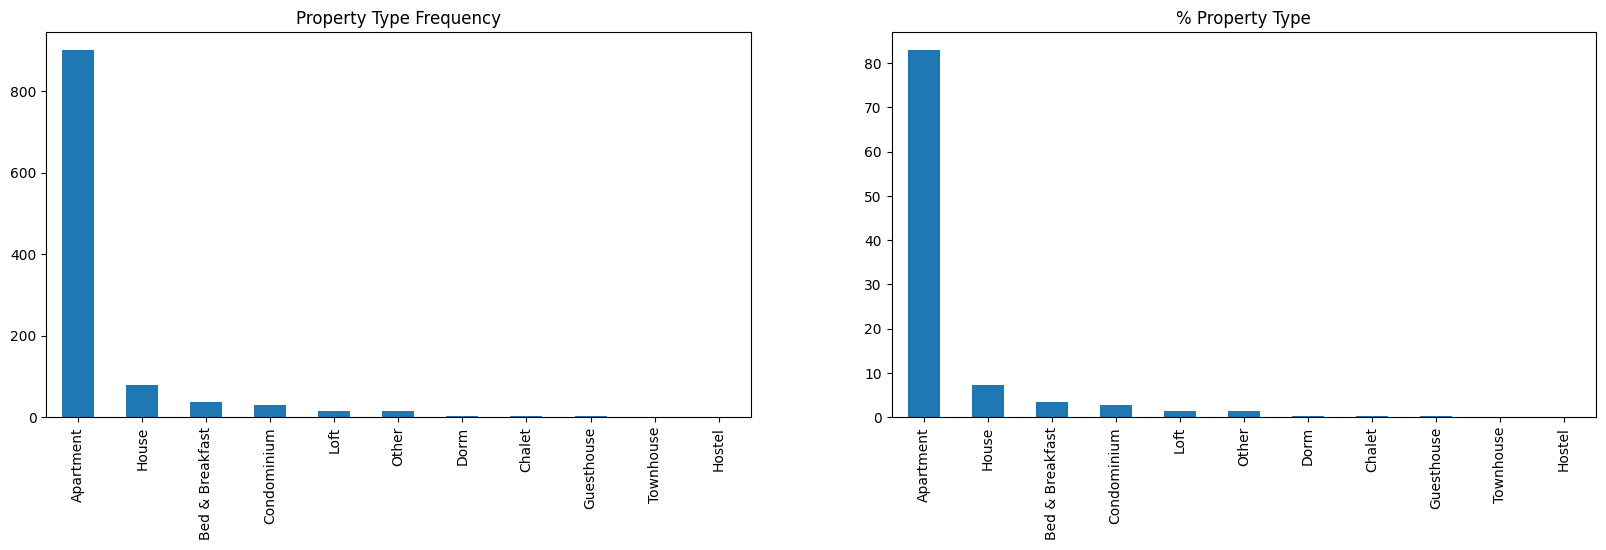

Más del 80% de los tipos de propiedad son Apartment. Nos quedaremos con sólo esos tipos de propiedad


In [48]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
data_train['Property Type'].value_counts().plot(kind='bar',title='Property Type Frequency')

plt.subplot(1,2, 2)
(100 * data_train['Property Type'].value_counts() / len(data_train['Property Type'])).plot(kind='bar', title='% Property Type')
plt.show()
print("Más del 80% de los tipos de propiedad son Apartment. Nos quedaremos con sólo esos tipos de propiedad")

In [49]:
data_train['Property Type'].value_counts()

Apartment          900
House               78
Bed & Breakfast     36
Condominium         31
Loft                16
Other               14
Dorm                 4
Chalet               3
Guesthouse           2
Townhouse            1
Hostel               1
Name: Property Type, dtype: int64

In [50]:
#Nos quedamos solo con los apartamentos
data_train  = data_train[data_train['Property Type']=="Apartment"]
data_train.drop(['Property Type'], axis=1, inplace=True)

#### Ciudad

In [51]:
unique_locations = data_train["City"].unique().astype(str)
for location in np.sort(unique_locations):
    print(location+" "+str(data_train[data_train["City"]==location].shape[0]))
print(len(unique_locations))
print("\n\n")
print("Se puede observar que la mayoría de los pisos se encuentras en Madrid nos quedaremos con los pisos que estén en Madrid ")

Alcúdia 1
Barcelona 19
Hospitalet de Llobregat 1
Madrid 868
Palma 5
Palma de Mallorca 1
Port d'Andratx 1
Pozuelo de Alarcón 1
Puerto ALCUDIA 1
Sóller 1
Torrenova 1
11



Se puede observar que la mayoría de los pisos se encuentras en Madrid nos quedaremos con los pisos que estén en Madrid 


In [52]:
#Nos quedamos con aquellos pisos que se encuentran en Madrid
data_train = data_train[data_train['City'].str.contains("Mad",na=False, case=False)]
#Country Code ya no aporta información al quedarnos con los airbnb de Madrid
data_train.drop(['Country Code'], axis=1, inplace=True)

#### Room Type

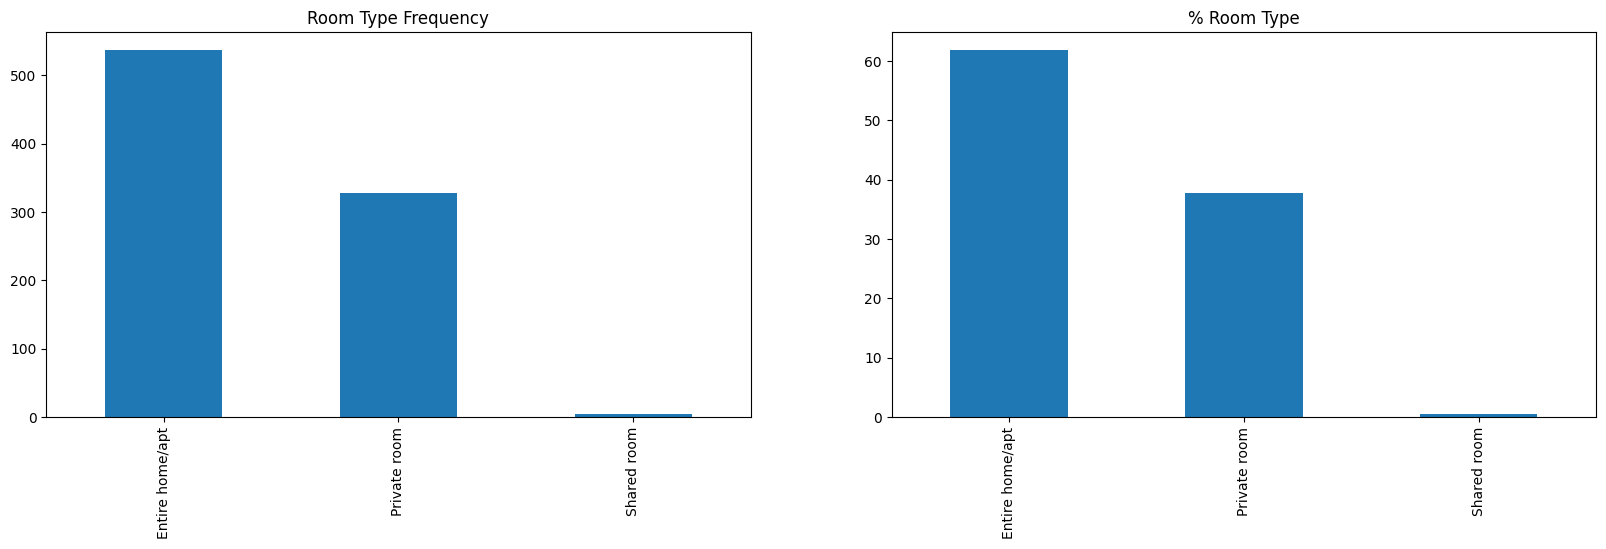

El 95% de los tipos de habitación son Entire home/apt o Private Room. Nos quedaremos con sólo esos tipos de habitaciones y eliminaremos las entradas con entrada 'Shared room'. Como es categórica la pasaremos más adelante a One Hot


In [53]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
data_train['Room Type'].value_counts().plot(kind='bar',title='Room Type Frequency')

plt.subplot(1,2, 2)
(100 * data_train['Room Type'].value_counts() / len(data_train['Room Type'])).plot(kind='bar', title='% Room Type')
plt.show()

print("El 95% de los tipos de habitación son Entire home/apt o Private Room. Nos quedaremos con sólo esos tipos de habitaciones y eliminaremos las entradas con entrada 'Shared room'. Como es categórica la pasaremos más adelante a One Hot")

In [54]:
	data_train = data_train[data_train['Room Type'] !="Shared room"]

#### Bed Type

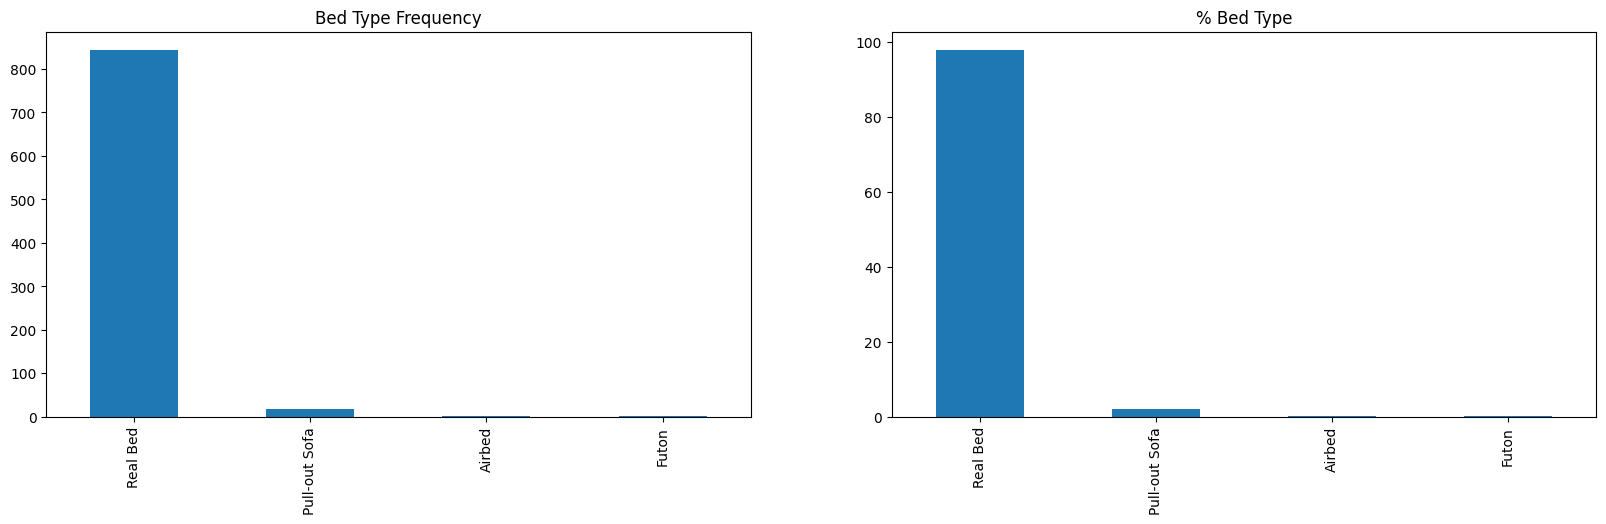

Nos quedamos con Bed type real bed que son casi el 100%


In [55]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
data_train['Bed Type'].value_counts().plot(kind='bar',title='Bed Type Frequency')

plt.subplot(1,2, 2)
(100 * data_train['Bed Type'].value_counts() / len(data_train['Bed Type'])).plot(kind='bar', title='% Bed Type')
plt.show()

print("Nos quedamos con Bed type real bed que son casi el 100%")

In [56]:
 #Bed type igual a Real bed
data_train = data_train [data_train['Bed Type'] =="Real Bed"]
#Eliminamos la columna
data_train.drop(['Bed Type'], axis=1, inplace=True)

#### Bathrooms

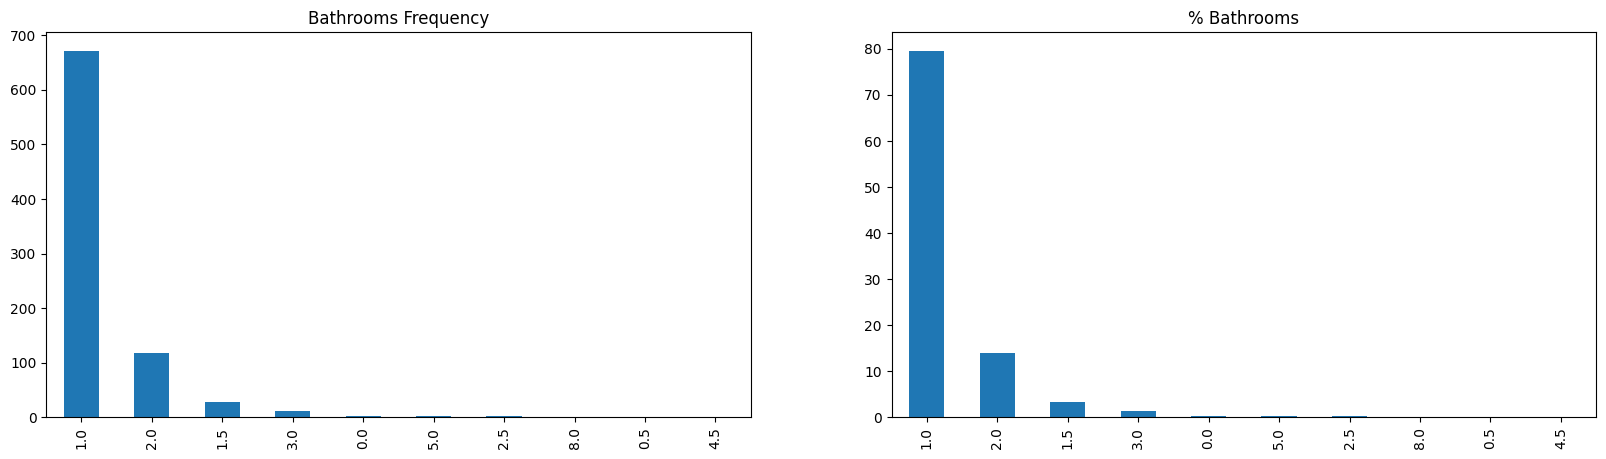

Más del 80% de los tipos de propiedad son Apartment. Nos quedaremos con sólo esos tipos de propiedad


In [57]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
data_train['Bathrooms'].value_counts().plot(kind='bar',title='Bathrooms Frequency')

plt.subplot(1,2, 2)
(100 * data_train['Bathrooms'].value_counts() / len(data_train['Bathrooms'])).plot(kind='bar', title='% Bathrooms')

plt.show()
print("Más del 80% de los tipos de propiedad son Apartment. Nos quedaremos con sólo esos tipos de propiedad")

## B.- Generación de variables

### Distancia Haversine

La longitud y longitud nos indican la geolocalización de los apartamentos. Como en el procesado nos hemos quedado con las ubicaciones de madrid, calcularemos la distancia que hay desde el centro de Madrid hasta el apartamento.

In [58]:
def haversine_distance(lat1, lon1, lat2, lon2):
	""" Calculo distancia haversine entre dos localizaciones

    Parámetros:
	lat1 -- latitud posición 1
	lon1 -- longitud posicion 1
	lat2 -- latitud posición 2
	lon2 -- longitud posición 2

    Returns:
	Distancia (en m) entre dos puntos
	"""
	lon1 = np.radians(lon1)
	lat1 = np.radians(lat1)
	lon2 = np.radians(lon2)
	lat2 = np.radians(lat2)

	r = 6371

	dlon = np.subtract(lon2, lon1)
	dlat = np.subtract(lat2, lat1)

	a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
               np.multiply(np.cos(lat1),
                           np.multiply(np.cos(lat2),
                                       np.power(np.sin(np.divide(dlon, 2)), 2))
                           )
              )
	c = np.multiply(2, np.arcsin(np.sqrt(a)))

	return c*r*1000

In [59]:
#Longitud y Latitud centro madrid para calcular la distancia haversine
centro_madrid_lat = 40.41831
centro_madrid_lon = -3.70275
data_train = data_train.assign(centro =  lambda x: haversine_distance(x['Latitude'],x['Longitude'],centro_madrid_lat,centro_madrid_lon))


#Eliminamos columnas las cuales hemos generado nuevas variables y se hace referencia a la localizacion
data_train.drop(['City','Longitude','Latitude',"Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)

### 'Features', 'Amenities', 'Host Verifications'

Las tres variables nos muestran una serie de cualidades de los apartamentos. Son todas listas separadas por comas. Contamos para cada una de ella el número de elementos que tiene en cada lista y lo usaremos como característica.



In [60]:
#Ejemplo de como quedarían las columnas
df_l = data_train[['Features', 'Amenities', 'Host Verifications']]
df_l.fillna("", inplace=True) # rellenamos los huecos con cadenas vacías

df_l['Features'] = df_l['Features'].apply(lambda x: len(str(x).split(',')))
df_l['Amenities'] = df_l['Amenities'].apply(lambda x: len(str(x).split(',')))
df_l['Host Verifications'] = df_l['Host Verifications'].apply(lambda x: len(str(x).split(',')))

df_l.head(5)

,Features,Amenities,Host Verifications
0,4,17,3
2,3,9,3
3,4,15,4
4,3,23,4
5,4,10,3


In [61]:
data_train['Features'].fillna("", inplace=True)
data_train['Amenities'].fillna("", inplace=True)
data_train['Host Verifications'].fillna("", inplace=True)

data_train['Features'] = data_train['Features'].apply(lambda x: len(str(x).split(',')))
data_train['Amenities'] = data_train['Amenities'].apply(lambda x: len(str(x).split(',')))
data_train['Host Verifications'] = data_train['Host Verifications'].apply(lambda x: len(str(x).split(',')))

### Antigüedad del dueño en la plataforma

In [62]:
from datetime import datetime

#Eliminamos registros con missing y na values
data_train.dropna(subset=['Host Since'], inplace=True)

#Calculamos la antiguedad del dueño en la plataforma.
data_train['Host Since'] = data_train['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
data_train['Years Being Host'] = data_train['Host Since'].apply(lambda x: 2017 - x.year)
data_train.drop(['Host Since'], axis=1, inplace=True)
data_train.drop(['Experiences Offered'], axis=1, inplace=True)

### Variables categóricas

In [63]:
col_num , col_not_num = tipo_columnas(data_train)

Columnas numéricas: 19 columnas.
Host Response Rate, Host Verifications, Bathrooms, Bedrooms, Beds, Amenities, Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights, Maximum Nights, Availability 365, Number of Reviews, Features, Average Review, centro, Years Being Host
Columnas no númericas: 3 columnas.
Host Response Time, Room Type, Cancellation Policy


Sólo nos quedan 3 variables categóricas , las convertimos a One-hot

In [64]:
#La variables categóricas que nos quedan tiene poco valores distintos
data_train[['Host Response Time','Room Type','Cancellation Policy']].apply(lambda x: len(x.unique()))

Host Response Time     5
Room Type              2
Cancellation Policy    3
dtype: int64

In [65]:
#Convertimos las variables a category para poder realizar despues one hot
data_train['Host Response Time'] = data_train['Host Response Time'].astype('category')
dummies_type_Host_Response_Time  = data_train['Host Response Time'].dtype
data_train['Room Type']          = data_train['Room Type'].astype('category')
dummies_type_Room_Type           = data_train['Room Type'].dtype
data_train['Cancellation Policy']= data_train['Cancellation Policy'].astype('category')
dummies_type_Cancellation_Policy = data_train['Cancellation Policy'].dtype
#Eliminamos columnas
data_train.drop(['Host Response Time','Room Type','Cancellation Policy'], axis=1, inplace=True)

## C- Correlación

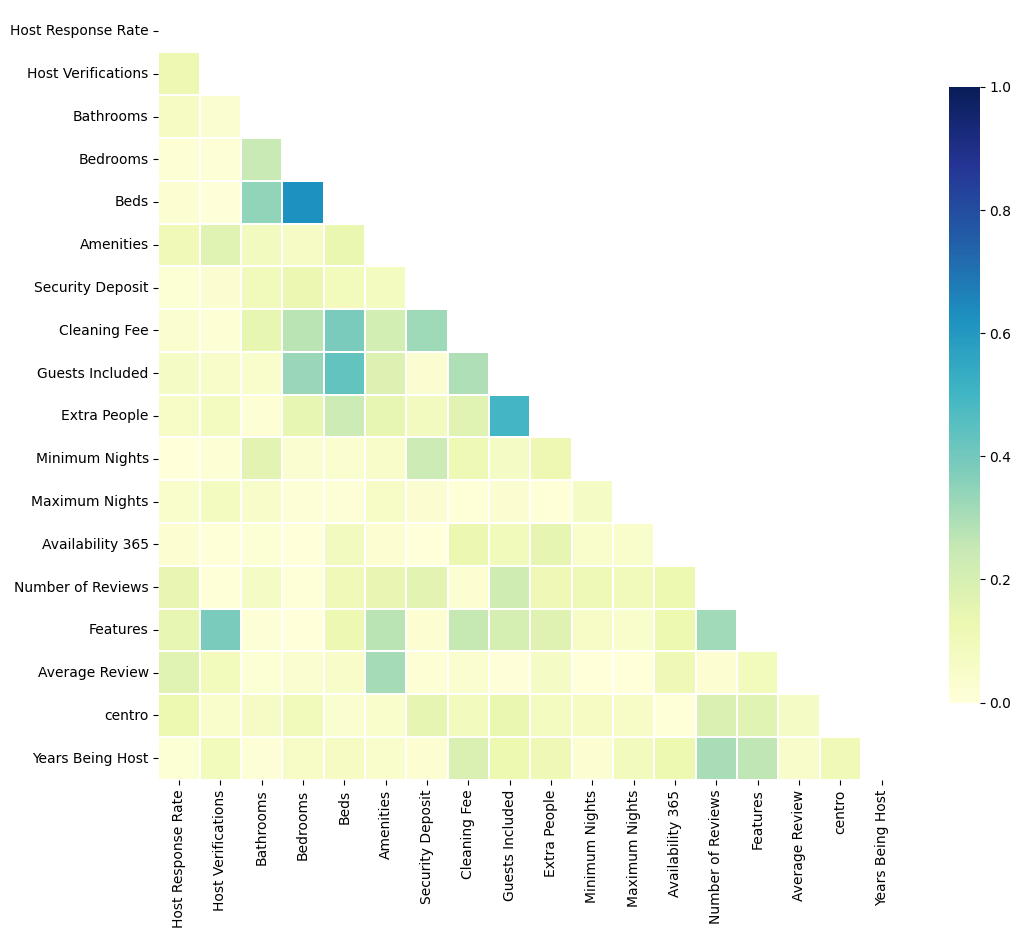

In [66]:
# Compute the correlation matrix
corr = np.abs(data_train.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [67]:
data_train[list(data_train.columns.values)].corr(numeric_only=True)

,Host Response Rate,Host Verifications,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Features,Average Review,centro,Years Being Host
Host Response Rate,1.000000,0.120952,-0.073633,-0.018554,0.025184,0.106455,0.055784,-0.021108,-0.035536,0.069633,0.055551,0.003460,-0.042767,-0.023604,0.141650,0.147259,0.165919,-0.127003,0.023424
Host Verifications,0.120952,1.000000,-0.035032,-0.013859,-0.006554,0.169918,0.060029,0.030462,-0.015887,0.054122,0.081658,-0.016379,-0.076409,0.011128,0.008674,0.383211,0.090995,-0.043650,0.090749
Bathrooms,-0.073633,-0.035032,1.000000,0.246044,0.346925,0.083231,0.090044,0.097384,0.146855,0.042418,0.018473,0.158364,0.052050,-0.023247,-0.067911,0.014566,0.022150,-0.062623,-0.012930
Bedrooms,-0.018554,-0.013859,0.246044,1.000000,0.623932,0.062603,0.395067,0.130706,0.269843,0.331946,0.147237,0.032494,0.015060,0.001655,0.009417,0.001345,-0.038878,0.099407,0.060824
Beds,0.025184,-0.006554,0.346925,0.623932,1.000000,0.140085,0.455366,0.093061,0.384540,0.430556,0.232235,-0.037572,0.011813,0.082048,0.104836,0.121596,-0.051222,0.037195,0.072071
Amenities,0.106455,0.169918,0.083231,0.062603,0.140085,1.000000,0.268943,0.081277,0.213172,0.178333,0.147411,-0.053402,-0.061296,0.026663,0.143853,0.271613,0.309049,-0.042377,0.045655
Price,0.055784,0.060029,0.090044,0.395067,0.455366,0.268943,1.000000,0.194234,0.614932,0.418361,0.209384,0.000380,0.042768,0.121050,0.084344,0.266354,0.092537,-0.226225,0.165332
Security Deposit,-0.021108,0.030462,0.097384,0.130706,0.093061,0.081277,0.194234,1.000000,0.320642,-0.030857,-0.084443,0.232926,-0.028469,-0.000678,-0.159553,-0.023813,0.018996,0.149449,0.024535
Cleaning Fee,-0.035536,-0.015887,0.146855,0.269843,0.384540,0.213172,0.614932,0.320642,1.000000,0.294988,0.170873,0.111417,0.008057,0.130833,-0.023893,0.250833,0.036129,-0.087606,0.188422
Guests Included,0.069633,0.054122,0.042418,0.331946,0.430556,0.178333,0.418361,-0.030857,0.294988,1.000000,0.497296,-0.066822,-0.028389,0.097949,0.224721,0.206257,0.006887,-0.136190,0.127127


Por último, podemos hacer una representación (scatter_plot) de todas las variables frente al resto, para tener una idea de cómo se relacionan las variables del problema.

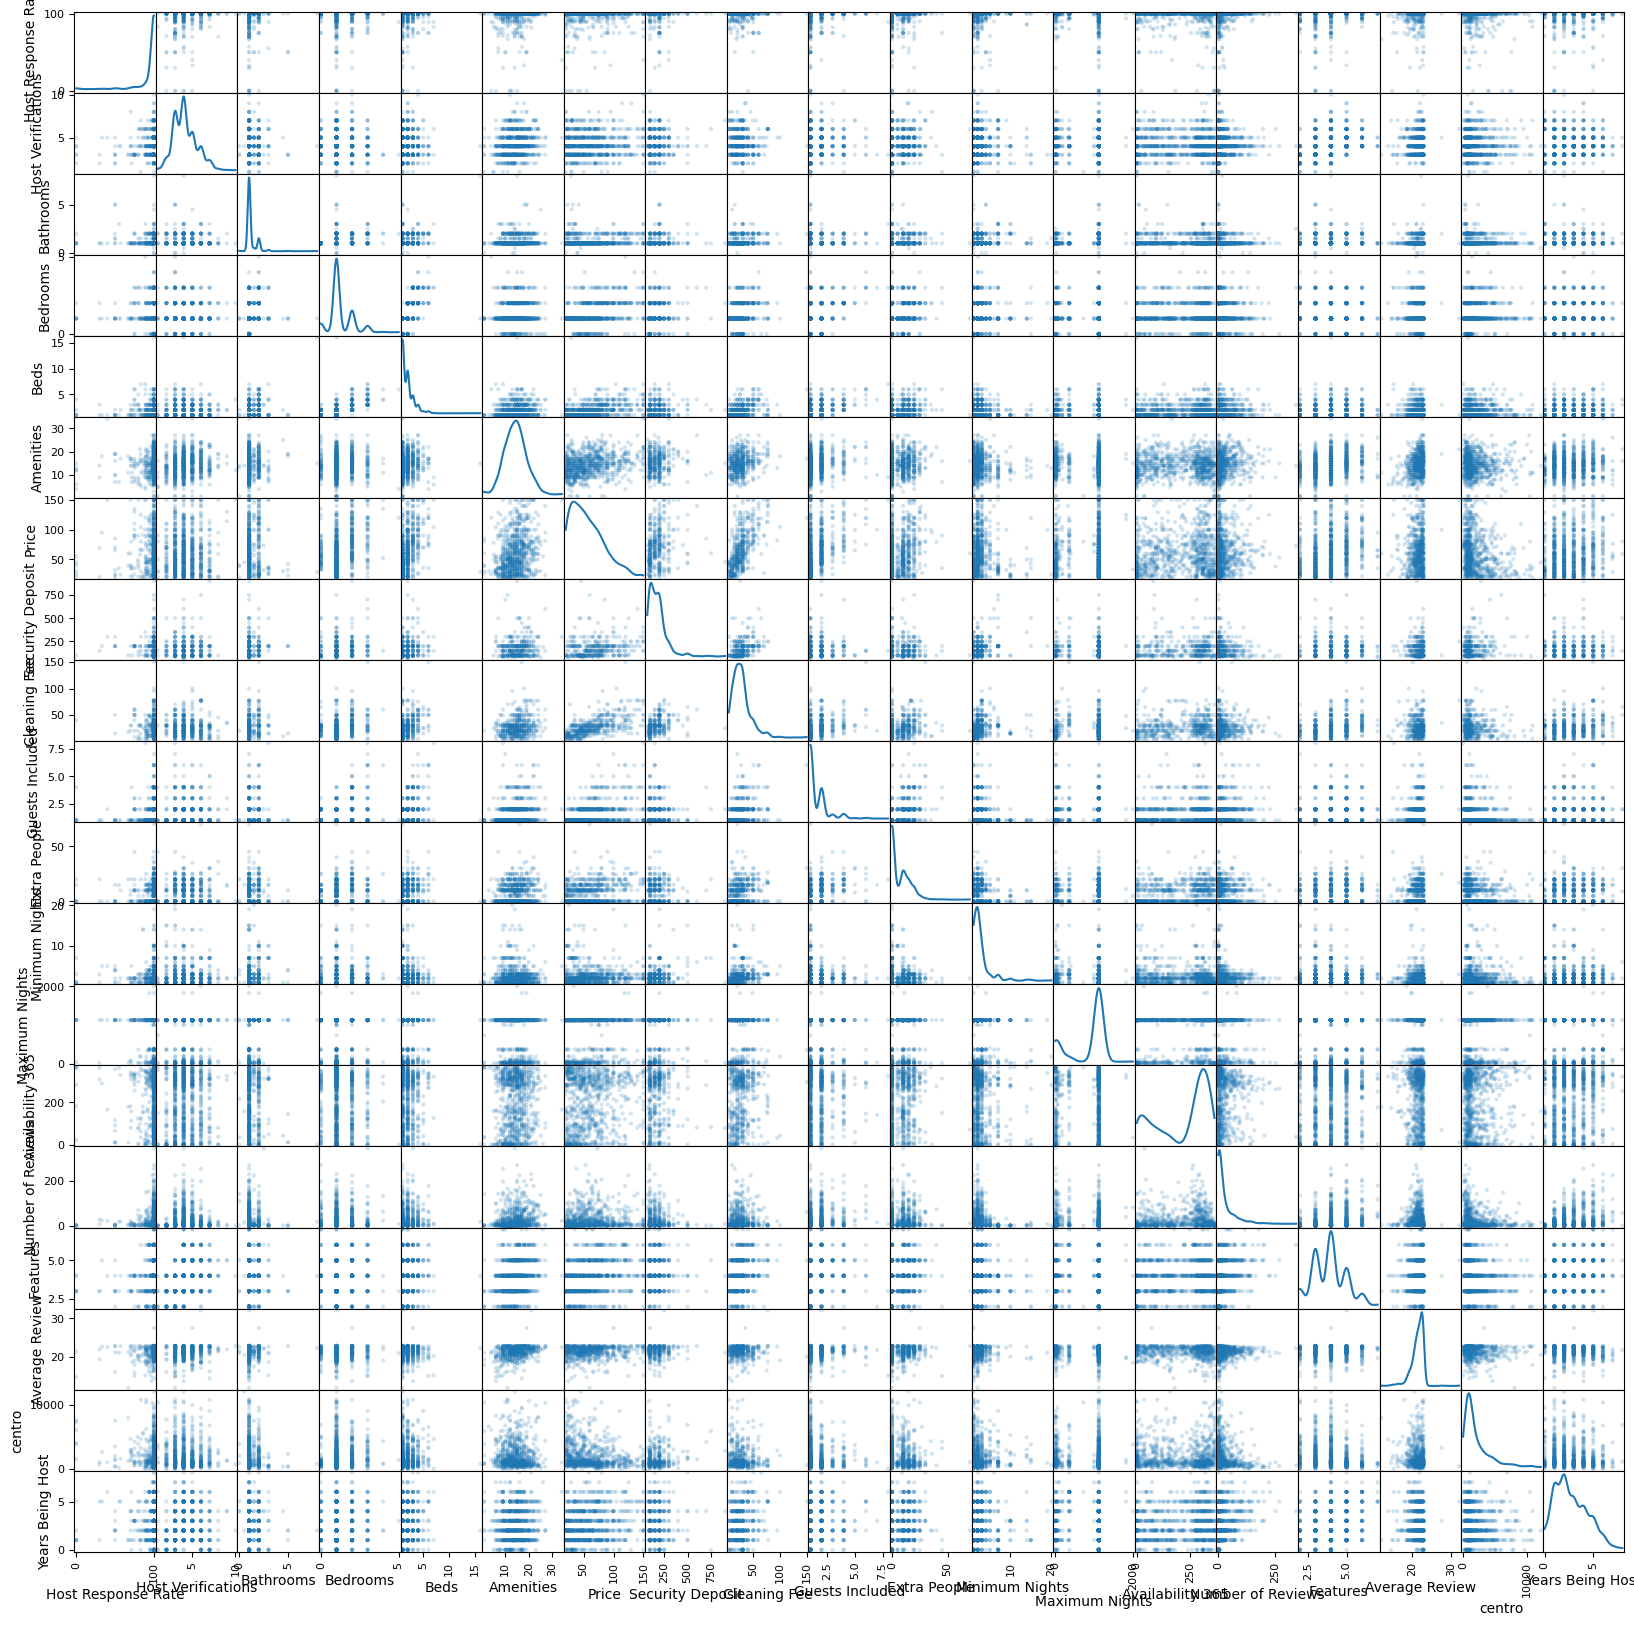

In [68]:
pd.plotting.scatter_matrix(data_train, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

## D.- Resumen preprocesamiento

In [69]:
def elimina_columnas(df,columnas):
	""" Elimina columna(s) de dataframe

	Parámetros:
	df -- dataframe a procesar
    columnas -- columna(s) a eliminar

	Returns:
	df - dataframe procesado por lo criterios optados en el procesamiento
	"""
	df = df.drop(columnas, axis=1)
	return df

def prepoc_df(df,imagenes):
	""" Procesamiento del dataframe con la ingeniería de características hecha en el procesamiento

	Parámetros:
	df - dataframe a procesar

	Returns:
	df - dataframe procesado por lo criterios optados en el procesamiento
	images - imagenes asociadas al dataframe
	"""


	#Longitud y Latitud centro madrid para calcular la distancia haversine
	centro_madrid_lat = 40.41831
	centro_madrid_lon = -3.70275


	not_useful_columns = [
			'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url',
			'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name',
			'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price',
			'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review',
			'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
			'Host Listings Count', 'Host Total Listings Count'
	]

	somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
				'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
				'Host Location', 'Host About']


	not_useful_columns_2 = ['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode']

	columns_with_too_many_missing_values = [
			'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
	]

  #Quitamos las columnas con su mayoría de variables a nulos
	df = elimina_columnas(df,not_useful_columns)
  #Quitamos aquellas variables que no aprotan valor a la solución del problema
	df = elimina_columnas(df,somehow_useful_columns_but_droppable_anyway)
   #Quitamos las columnas con su mayoría de variables a nulos
	df = elimina_columnas(df,not_useful_columns_2)
  #Quitamos aquellas variables que no aprotan valor a la solución del problema
	df = elimina_columnas(df,columns_with_too_many_missing_values)
  #Price entre 20 y 120 €
	df = df [(df['Price']>20) & (df['Price']<150)]
  #Nos quedamos solo con los apartamentos
	df  = df[df['Property Type']=="Apartment"]
	df = elimina_columnas(df,['Property Type'])
	#Nos quedamos con aquellos pisos que se encuentran en Madrid
	df = df[df['City'].str.contains("Mad",na=False, case=False)]
  #Room type diferente a shared
	df = df [df['Room Type'] !="Shared room"]
  #Bed type igual a Real bed
	df = df [df['Bed Type'] =="Real Bed"]
	df = elimina_columnas(df,['Bed Type'])
	#Quitamos entradas con 0 baños
	df = df[df['Bathrooms'] != 0]
  #Aplicamos distancia harvesine para saber a qué distancia del centro están
	df = df .assign(centro =  lambda x: haversine_distance(x['Latitude'],x['Longitude'],centro_madrid_lat,centro_madrid_lon))
  #Eliminamos columnas las cuales hemos generado nuevas variables relacionado con la localización
	df = elimina_columnas(df,['City','Longitude','Latitude',"Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"])


	#medias reviews
	reviews = df.loc[: , "Review Scores Rating":"Review Scores Value"]
	df['Average Review'] = reviews.mean(axis=1)

	df.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating',
				   'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
					 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
					 'Accommodates'], axis=1, inplace=True)


	#Features , Amenities , Host verifications conteo
	df['Features'].fillna("", inplace=True)
	df['Amenities'].fillna("", inplace=True)
	df['Host Verifications'].fillna("", inplace=True)

	df['Features'] = df['Features'].apply(lambda x: len(str(x).split(',')))
	df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))
	df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))


	#años de inquilino
	from datetime import datetime
	df.dropna(subset=['Host Since'], inplace=True)
	df['Host Since'] = df['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
	df['Years Being Host'] = df['Host Since'].apply(lambda x: 2017 - x.year)
	df.drop(['Host Since'], axis=1, inplace=True)


	df["Host Response Time"].fillna(df["Host Response Time"].mode()[0], inplace=True)
	df.drop(['Experiences Offered'], axis=1, inplace=True)
	df.drop(['Country Code'], axis=1, inplace=True)


	# Variable categóricas a numéricas
	df['Host Response Time']  = df['Host Response Time'].astype(dummies_type_Host_Response_Time)
	df['Room Type'] 				  = df['Room Type'].astype(dummies_type_Room_Type)
	df['Cancellation Policy'] = df['Cancellation Policy'].astype(dummies_type_Cancellation_Policy)
	Host_Response_Time  = pd.get_dummies(df[['Host Response Time']], prefix='Host_Response_Time')
	Room_Type           = pd.get_dummies(df[['Room Type']], prefix='Room_Type')
	Cancellation_Policy = pd.get_dummies(df[['Cancellation Policy']], prefix='Cancellation_Policy')

	categorical_data = pd.concat([Host_Response_Time,Room_Type,Cancellation_Policy], axis=1, join='inner')
	df = pd.concat([df,categorical_data], axis=1)

	df = elimina_columnas(df,['Host Response Time','Room Type','Cancellation Policy'])



	# Rellenamos valores nulos sobrantes con la media
	df.fillna(df.mean(), inplace=True)


	#Nos quedamos con las imagenes de los registros válidos
	indices = df.index
	imagenes = imagenes[indices]

	return df , imagenes


In [70]:
#Cargamos los datos de validación
data_valid  = pd.read_csv("valid_airbnb.csv", sep=';', decimal='.')
images_valid = np.load("valid_images_airbnb.npy")


#Cargamos los datos de test
data_test   = pd.read_csv('test_airbnb.csv', sep=';', decimal='.')
images_test = np.load("test_images_airbnb.npy")


In [71]:
df_train_prepoc,images_train = prepoc_df(data_train_aux,images_train)
df_valid_prepoc,images_valid = prepoc_df(data_valid,images_valid)
df_test_prepoc,images_test   = prepoc_df(data_test,images_test)

In [72]:
print(f'Dimensiones del dataset de train antes del preprocesamiento:   {data_train_aux.shape}')
print(f'Dimensiones del dataset de valid antes del preprocesamiento:   {data_valid.shape}')
print(f'Dimensiones del dataset de test  antes del preprocesamiento:   {data_test.shape}')
print(f'Dimensiones del dataset de train después del preprocesamiento: {df_train_prepoc.shape}')
print(f'Dimensiones del dataset de valid después del preprocesamiento: {df_valid_prepoc.shape}')
print(f'Dimensiones del dataset de test  después del preprocesamiento: {df_test_prepoc.shape}')

Dimensiones del dataset de train antes del preprocesamiento:   (1235, 89)
Dimensiones del dataset de valid antes del preprocesamiento:   (155, 89)
Dimensiones del dataset de test  antes del preprocesamiento:   (154, 89)
Dimensiones del dataset de train después del preprocesamiento: (792, 28)
Dimensiones del dataset de valid después del preprocesamiento: (88, 28)
Dimensiones del dataset de test  después del preprocesamiento: (94, 28)


Comprobamos que no haya valores nulos

In [73]:
df_train_prepoc.isna().sum()

Host Response Rate                       0
Host Verifications                       0
Bathrooms                                0
Bedrooms                                 0
Beds                                     0
Amenities                                0
Price                                    0
Security Deposit                         0
Cleaning Fee                             0
Guests Included                          0
Extra People                             0
Minimum Nights                           0
Maximum Nights                           0
Availability 365                         0
Number of Reviews                        0
Features                                 0
centro                                   0
Average Review                           0
Years Being Host                         0
Host_Response_Time_a few days or more    0
Host_Response_Time_within a day          0
Host_Response_Time_within a few hours    0
Host_Response_Time_within an hour        0
Room_Type_E

In [74]:
	df_train_prepoc.isnull().any()

Host Response Rate                       False
Host Verifications                       False
Bathrooms                                False
Bedrooms                                 False
Beds                                     False
Amenities                                False
Price                                    False
Security Deposit                         False
Cleaning Fee                             False
Guests Included                          False
Extra People                             False
Minimum Nights                           False
Maximum Nights                           False
Availability 365                         False
Number of Reviews                        False
Features                                 False
centro                                   False
Average Review                           False
Years Being Host                         False
Host_Response_Time_a few days or more    False
Host_Response_Time_within a day          False
Host_Response

## Datos train/valid/test procesados : Escalado

In [75]:
col_num , col_not_num = tipo_columnas(df_train_prepoc)

Columnas numéricas: 28 columnas.
Host Response Rate, Host Verifications, Bathrooms, Bedrooms, Beds, Amenities, Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights, Maximum Nights, Availability 365, Number of Reviews, Features, centro, Average Review, Years Being Host, Host_Response_Time_a few days or more, Host_Response_Time_within a day, Host_Response_Time_within a few hours, Host_Response_Time_within an hour, Room_Type_Entire home/apt, Room_Type_Private room, Cancellation_Policy_flexible, Cancellation_Policy_moderate, Cancellation_Policy_strict
Columnas no númericas: 0 columnas.



In [76]:
#Creación X_train , y_train , X_test e y_test
features = df_train_prepoc[col_num].columns.drop(['Price'])
X_train  = df_train_prepoc[features].values
y_train  = df_train_prepoc['Price'].values
X_valid  = df_valid_prepoc[features].values
y_valid  = df_valid_prepoc['Price'].values
X_test   = df_test_prepoc[features].values
y_test   = df_test_prepoc['Price'].values


#Escalamos entre 0 y 1 (con los datos de train)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(f'{X_train.shape} Dimensiones de train')
print(f'{X_valid.shape}  Dimensiones de valid')
print(f'{X_test.shape}  Dimensiones de test')
print(f'{y_train.shape} Dimensiones variable objetivo train')
print(f'{y_valid.shape} Dimensiones variable objetivo valid')
print(f'{y_test.shape}  Dimensiones variable objetivo test')

(792, 27) Dimensiones de train
(88, 27)  Dimensiones de valid
(94, 27)  Dimensiones de test
(792,) Dimensiones variable objetivo train
(88,) Dimensiones variable objetivo valid
(94,)  Dimensiones variable objetivo test


## Datos train/valid/test procesados : One-hot variable a predecir

Para simplifica el problema lo convertiré en un problema de clasificación multiclase. Habra 3 etiquetas



*   0 ➝ Precio por debajo de 45 €
*   1 ➝ Precio entre 45 y 70 €
*   2 ➝ Precio superior a 70 €




In [77]:
y_train_multiclass = np.where(y_train < 45, 0 , (np.where(   np.logical_and(y_train >= 45,y_train <= 70) , 1 ,2)))
y_valid_multiclass = np.where(y_valid < 45, 0 , (np.where(   np.logical_and(y_valid >= 45,y_valid <= 70) , 1 ,2)))
y_test_multiclass  = np.where(y_test  < 45, 0  ,(np.where(   np.logical_and(y_test  >= 45,y_test  <= 70) , 1 ,2)))

In [78]:
np.unique(y_train_multiclass, return_counts=True),np.unique(y_valid_multiclass, return_counts=True),np.unique(y_test_multiclass, return_counts=True)

((array([0, 1, 2]), array([277, 270, 245])),
 (array([0, 1, 2]), array([32, 24, 32])),
 (array([0, 1, 2]), array([33, 37, 24])))

Se observa que hay un balanceo de clases dentro de las tres particiones train/valid/test.

In [79]:
y_train_multiclass_cat =  to_categorical(y_train_multiclass)
y_valid_multiclass_cat =  to_categorical(y_valid_multiclass)
y_test_multiclass_cat  =  to_categorical(y_test_multiclass)

Las etiquetas a predecir pueden ser

*   y_<train/valid/test>_multiclass     : Labels numéricas (0,1,2)  
*   y_<train/valid/test>_multiclass_cat : Labels onehot (1 ->  [1,0,0], 2 -> [0,1,0], 3 -> [0,0,1])



# 4.- Modelado

## Funciones auxiliares modelado

In [80]:
#Representación gráfica de la curvas loss / acurracy en train y validation
def plot_loss_curves(history):
  # """
  # Returns separate loss curves for training and validation metrics.

  # Args:
  #   history: TensorFlow model History object
  # """
  # loss = history.history['loss']
  # val_loss = history.history['val_loss']

  # accuracy = history.history['accuracy']
  # val_accuracy = history.history['val_accuracy']

  # epochs = range(len(history.history['loss']))

  # # Plot loss
  # plt.plot(epochs, loss, label='training_loss')
  # plt.plot(epochs, val_loss, label='val_loss')
  # plt.title('Loss')
  # plt.xlabel('Epochs')
  # plt.legend()

  # # Plot accuracy
  # plt.figure()
  # plt.plot(epochs, accuracy, label='training_accuracy')
  # plt.plot(epochs, val_accuracy, label='val_accuracy')
  # plt.title('Accuracy')
  # plt.xlabel('Epochs')
  # plt.legend();

  """
  Returns separate loss curves for training and validation metrics in two columns.

  Args:
    history: TensorFlow model History object
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Create subplots with 1 row and 2 columns
  plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
  plt.subplots_adjust(wspace=0.3)  # Adjust the horizontal space between subplots

  # Plot loss in the first subplot (1, 2, 1)
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy in the second subplot (1, 2, 2)
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  plt.show()

In [81]:
from sklearn.metrics import confusion_matrix
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## Primer módulo: Estimacion datos tabulares e imágenes

### Datos tabulares

#### multiclass classification

In [82]:
# Creamos un modelo para hacer primero clasificación multiclase
print(f"Input size: {X_train.shape[1]}")

num_clases =3
classificator1D = tf.keras.Sequential(name="Clasificador_datos_tabulares")
classificator1D.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
classificator1D.add(Dense(32, activation='relu'))
classificator1D.add(Dropout(0.2))
classificator1D.add(Dense(8, activation='relu'))
classificator1D.add(Dense(num_clases, activation='softmax')) # Sin función de activación

Input size: 27


In [83]:
classificator1D.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
classificator1D.summary()

Model: "Clasificador_datos_tabulares"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 4163 (16.26 KB)
Trainable params: 4163 (16.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


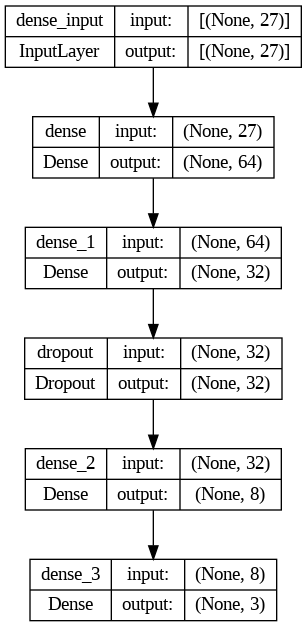

In [84]:
plot_model(classificator1D, show_shapes=True, show_layer_names=True)

In [85]:
# Entrenamos un número fijo de épocas
EPOCHS = 15
BS = 32

history_classificator1D = classificator1D.fit(x=X_train,
                        y=y_train_multiclass_cat,
                        batch_size=BS,
                        epochs=EPOCHS,
                        validation_data=(X_valid, y_valid_multiclass_cat),
                        verbose=1)

Epoch 1/15
25/25 [==============================] - 7s 21ms/step - loss: 1.0376 - accuracy: 0.4596 - val_loss: 0.9109 - val_accuracy: 0.6023
Epoch 2/15
25/25 [==============================] - 0s 7ms/step - loss: 0.8813 - accuracy: 0.5947 - val_loss: 0.8026 - val_accuracy: 0.6705
Epoch 3/15
25/25 [==============================] - 0s 7ms/step - loss: 0.7893 - accuracy: 0.6389 - val_loss: 0.7442 - val_accuracy: 0.7273
Epoch 4/15
25/25 [==============================] - 0s 7ms/step - loss: 0.7337 - accuracy: 0.6755 - val_loss: 0.7218 - val_accuracy: 0.7045
Epoch 5/15
25/25 [==============================] - 0s 7ms/step - loss: 0.6850 - accuracy: 0.6894 - val_loss: 0.7106 - val_accuracy: 0.6932
Epoch 6/15
25/25 [==============================] - 0s 8ms/step - loss: 0.6666 - accuracy: 0.7121 - val_loss: 0.7008 - val_accuracy: 0.6932
Epoch 7/15
25/25 [==============================] - 0s 7ms/step - loss: 0.6367 - accuracy: 0.7197 - val_loss: 0.6991 - val_accuracy: 0.6818
Epoch 8/15
25/25 [=

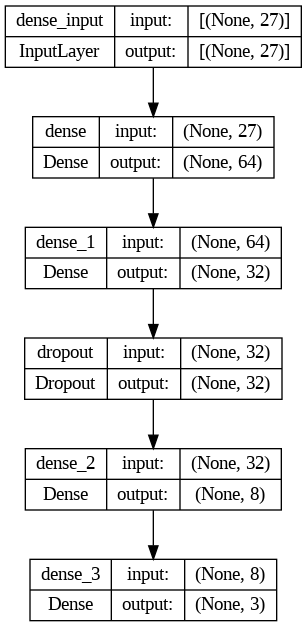

In [86]:
plot_model(classificator1D, show_shapes=True, show_layer_names=True)

In [87]:
classificator1D.evaluate(X_test, y_test_multiclass_cat, verbose=1)

3/3 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.6702


[0.682231605052948, 0.6702127456665039]

3/3 [==============================] - 0s 3ms/step


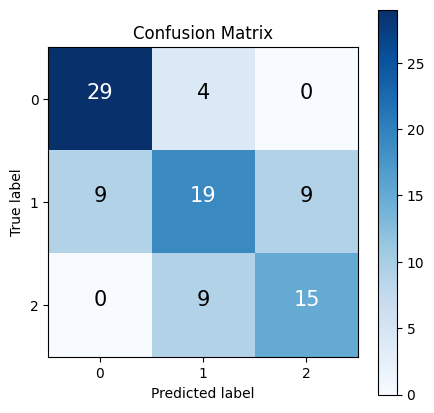

In [88]:
y_true = np.argmax(y_test_multiclass_cat,axis = 1)
y_pred = np.argmax(classificator1D.predict(X_test),axis = 1)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

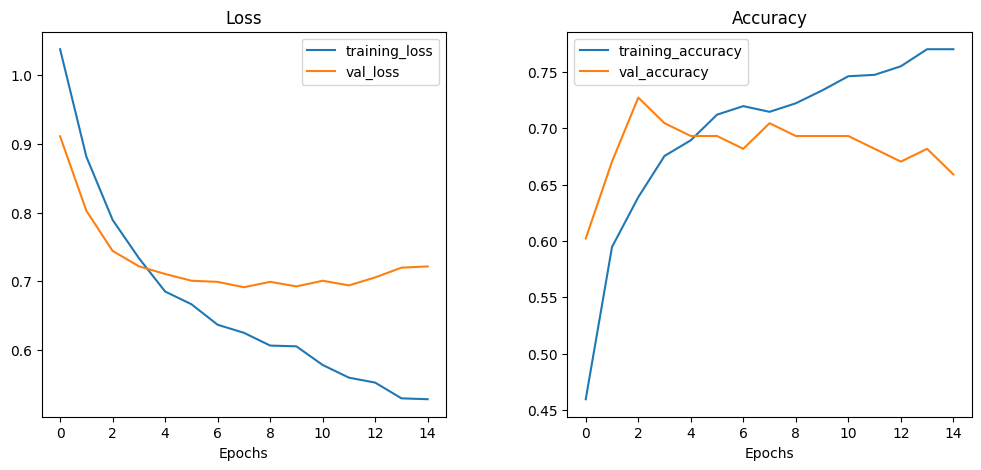

In [89]:
plot_loss_curves(history_classificator1D)

### Clasificación imágenes

Probaré diferentes extractores de características. Debido a que están hecho para clasificar entre 100 etiquetas, haré fine-tuning para que se adapte al problema que tenemos y sólo clasifique en 3.

#### Imágenes : Mobilenet_v2

In [90]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [91]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [92]:
num_classes = 3

model_mobilenet_v2 = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes,activation='softmax'),
],name="mobilenet_v2_transfer_learning")

model_mobilenet_v2.summary()

Model: "mobilenet_v2_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2586691 (9.87 MB)
Trainable params: 328707 (1.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


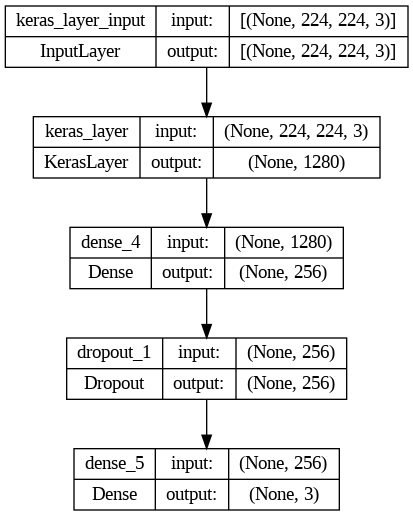

In [93]:
plot_model(model_mobilenet_v2, show_shapes=True, show_layer_names=True)

In [94]:
model_mobilenet_v2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [95]:
NUM_EPOCHS = 5
history_mobilenet_v2 = model_mobilenet_v2.fit(x=images_train,
                                              y=y_train_multiclass_cat,
                                              validation_data=(images_valid, y_valid_multiclass_cat),
                                              epochs=NUM_EPOCHS,
                                              verbose=1)

Epoch 1/5
25/25 [==============================] - 12s 96ms/step - loss: 1.2693 - accuracy: 0.4078 - val_loss: 1.1121 - val_accuracy: 0.4432
Epoch 2/5
25/25 [==============================] - 1s 47ms/step - loss: 0.9153 - accuracy: 0.5619 - val_loss: 1.0984 - val_accuracy: 0.4091
Epoch 3/5
25/25 [==============================] - 1s 49ms/step - loss: 0.8210 - accuracy: 0.6098 - val_loss: 1.0787 - val_accuracy: 0.4318
Epoch 4/5
25/25 [==============================] - 1s 46ms/step - loss: 0.7145 - accuracy: 0.6806 - val_loss: 1.1075 - val_accuracy: 0.4886
Epoch 5/5
25/25 [==============================] - 1s 49ms/step - loss: 0.6053 - accuracy: 0.7689 - val_loss: 1.1857 - val_accuracy: 0.4205


In [96]:
model_mobilenet_v2.evaluate(images_test, y_test_multiclass_cat, verbose=1)

3/3 [==============================] - 1s 355ms/step - loss: 1.1834 - accuracy: 0.4468


[1.1833566427230835, 0.44680851697921753]

3/3 [==============================] - 1s 32ms/step


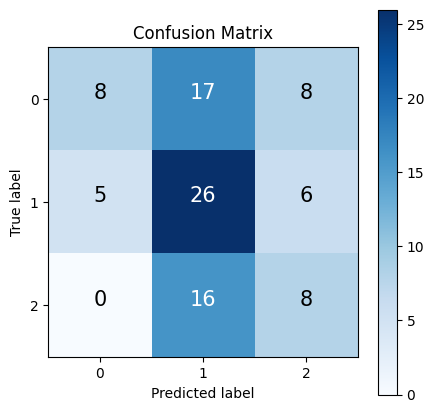

In [97]:
y_true = np.argmax(y_test_multiclass_cat,axis = 1)
y_pred = np.argmax(model_mobilenet_v2.predict(images_test),axis = 1)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

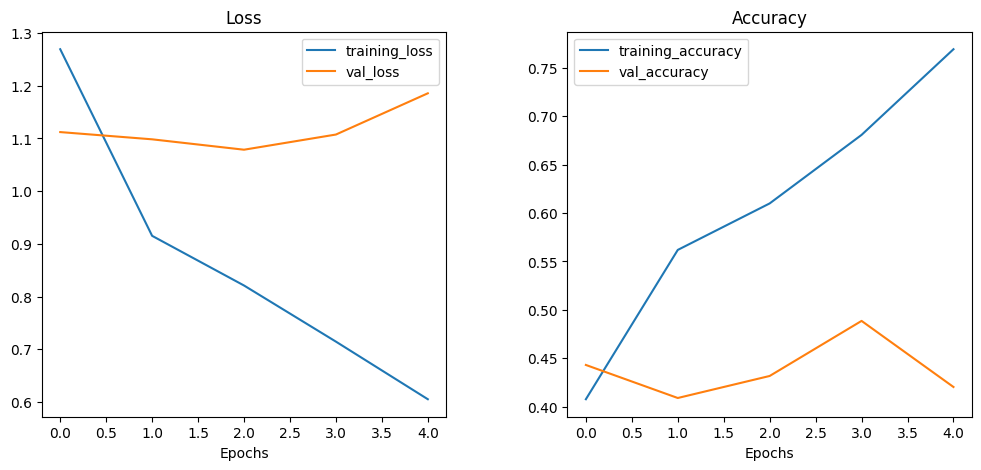

In [98]:
plot_loss_curves(history_mobilenet_v2)

#### Imágenes : Inception_v3

In [99]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

In [100]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [101]:
num_classes = 3

model_inception_v3 = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes,activation='softmax'),
],name="inception_v3_transfer_learning")

model_inception_v3.summary()

Model: "inception_v3_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22328099 (85.17 MB)
Trainable params: 525315 (2.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [102]:
model_inception_v3.compile(
  optimizer="adam",
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [103]:
NUM_EPOCHS = 3

history_inception_v3 = model_inception_v3.fit( x=images_train,
                                              y=y_train_multiclass_cat,
                                              validation_data=(images_valid, y_valid_multiclass_cat),
                                              epochs=NUM_EPOCHS,
                                              verbose=1)

Epoch 1/3
25/25 [==============================] - 18s 240ms/step - loss: 1.8225 - accuracy: 0.3662 - val_loss: 1.0642 - val_accuracy: 0.3636
Epoch 2/3
25/25 [==============================] - 2s 86ms/step - loss: 1.0591 - accuracy: 0.4722 - val_loss: 1.0661 - val_accuracy: 0.4659
Epoch 3/3
25/25 [==============================] - 2s 83ms/step - loss: 0.9623 - accuracy: 0.5088 - val_loss: 1.0411 - val_accuracy: 0.5000


In [104]:
model_inception_v3.evaluate(images_test, y_test_multiclass_cat, verbose=1)

3/3 [==============================] - 2s 930ms/step - loss: 1.0014 - accuracy: 0.4574


[1.0013952255249023, 0.457446813583374]

3/3 [==============================] - 1s 61ms/step


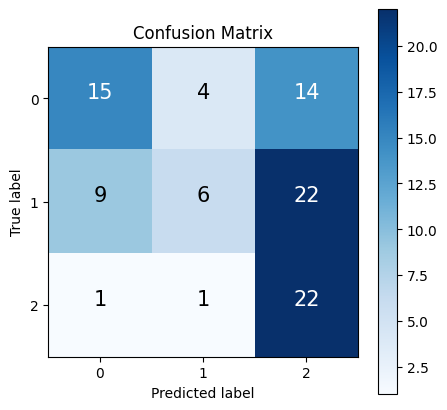

In [105]:
y_true = np.argmax(y_test_multiclass_cat,axis = 1)
y_pred = np.argmax(model_inception_v3.predict(images_test),axis = 1)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

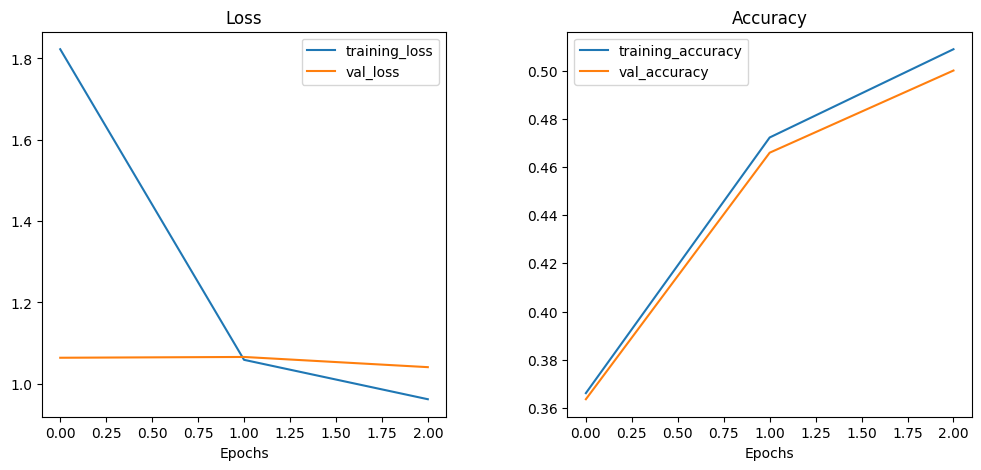

In [106]:
plot_loss_curves(history_inception_v3)

#### Imágenes : ResNet50

In [107]:
input_shape = images_train[0].shape
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#base_resnet.summary()

94765736/94765736 [==============================] - 0s 0us/step


In [108]:
num_classes = 3

model_resnet50 = tf.keras.Sequential([
  base_resnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes,activation='softmax'),
],name="RESNET50_transfer_learning")

model_resnet50.summary()

Model: "RESNET50_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24113027 (91.98 MB)
Trainable params: 24059907 (91.78 MB)
Non-trainable params: 53120 (207.5

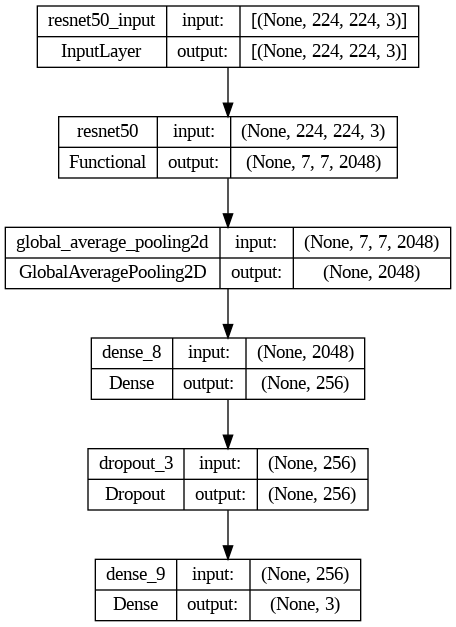

In [109]:
plot_model(model_resnet50, show_shapes=True, show_layer_names=True)

In [110]:
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
NUM_EPOCHS = 2

history_resnet50 = model_resnet50.fit( x=images_train,
                                       y=y_train_multiclass_cat,
                                       validation_data=(images_valid, y_valid_multiclass_cat),
                                       epochs=NUM_EPOCHS,
                                       verbose=1)

Epoch 1/2
25/25 [==============================] - 53s 467ms/step - loss: 1.3700 - accuracy: 0.4078 - val_loss: 180149.1875 - val_accuracy: 0.3636
Epoch 2/2
25/25 [==============================] - 8s 320ms/step - loss: 1.0956 - accuracy: 0.4419 - val_loss: 30332.3750 - val_accuracy: 0.3636


In [112]:
model_resnet50.evaluate(images_test, y_test_multiclass_cat, verbose=1)

3/3 [==============================] - 1s 651ms/step - loss: 34003.7500 - accuracy: 0.3511


[34003.75, 0.3510638177394867]

3/3 [==============================] - 2s 113ms/step


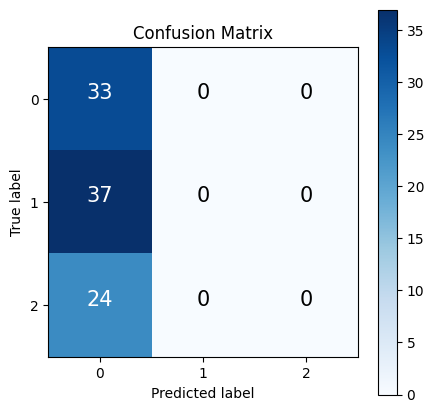

In [113]:
y_true = np.argmax(y_test_multiclass_cat,axis = 1)
y_pred = np.argmax(model_resnet50.predict(images_test),axis = 1)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

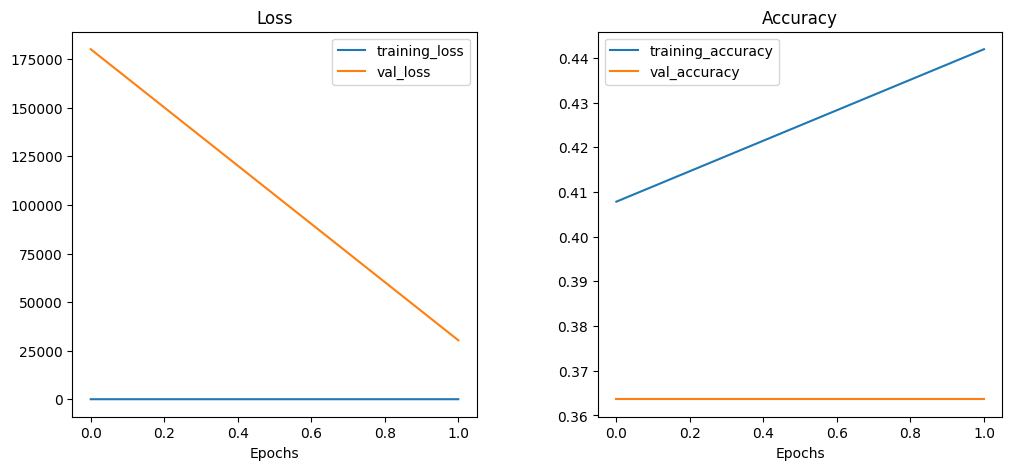

In [114]:
plot_loss_curves(history_resnet50)

## Segundo módulo: Combinación datos tabulares e imágenes

Debido a que en los modelos de Machine Learning no vamos a usar validación, juntaremos train con validación

### Early Fusion

Para realizar earlyfusión debimos juntar las características de ambos tipos de datos.

* Datos tabualres : 27 características.
* Imágenes : 224*224*3 = 150.528 características.

Vemos que hay un desbalanceo entre las características que aporta la información de diferentes tipos por lo cual se procederá a reducir la dimensionalidad de las imágenes.

In [115]:
# En datos tabulares(DT), la representación es la misma que de entrada al modelo correspondiente
early_DT_train = np.concatenate((X_train,X_valid), axis=0)
early_DT_train.shape

(880, 27)

In [116]:
# En las imágenes, tenemos que definir un "nuevo modelo" para obtener características
last_layer = model_mobilenet_v2.layers[-3].output
feature_extractor = Model(model_mobilenet_v2.input, last_layer)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_input (InputLa  [(None, 224, 224, 3)]     0         
 yer)                                                            
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
Total params: 2585920 (9.86 MB)
Trainable params: 327936 (1.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [117]:
# Obtenemos así features para train/val/test images
early_images_train = feature_extractor.predict(images_train)
early_images_valid = feature_extractor.predict(images_valid)
early_images_test  = feature_extractor.predict(images_test)

print(early_images_train.shape)

3/3 [==============================] - 0s 30ms/step
(792, 256)


Los datos tabulares tienen 27 características mientras que las imagénes poseee 256 características. Por lo cual se reducirá la dimensionalidad otra vez mediante el algoritmo PCA.

In [118]:
from sklearn.decomposition import PCA

# Mismo orden de características que datos tabulares
pca = PCA(n_components=27, random_state=420)
early_images_train_pca = pca.fit_transform(early_images_train)
early_images_valid_pca = pca.transform(early_images_valid)
early_images_test_pca = pca.transform(early_images_test)

early_images_train_pca.shape

(792, 27)

In [119]:
# Combinamos ambas representaciones (tabular + features-PCA)
early_train_features = np.concatenate((early_DT_train, np.concatenate((early_images_train_pca, early_images_valid_pca))),axis=1)
early_test_features  = np.concatenate((X_test, early_images_test_pca), axis=1)

#Labes train / test
y_labels_train = np.concatenate((y_train_multiclass, y_valid_multiclass))
y_labels_test  = y_test_multiclass

#### SVC

In [120]:
early_fuser = SVC(random_state=42)
early_fuser.fit(X=early_train_features, y=y_labels_train)
acc_SVC_early = early_fuser.score(X=early_test_features, y=y_labels_test)
print(f"Early fusion SVC  {round(acc_SVC_early*100,2)}% accuracy")

Early fusion SVC  58.51% accuracy


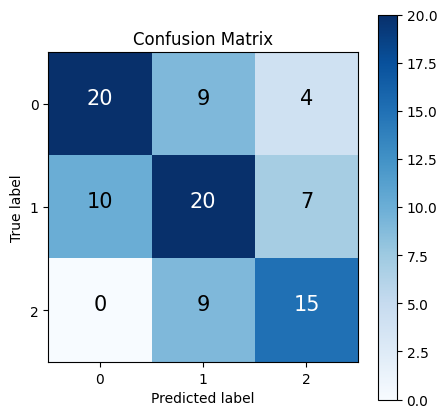

In [121]:
y_true = y_labels_test
y_pred = early_fuser.predict(early_test_features)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

#### GradientBoostingClassifier

In [122]:
from sklearn.ensemble import GradientBoostingClassifier

In [123]:
GBClass = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0).fit(X=early_train_features, y=y_labels_train)
acc_GBClass_early = GBClass.score(X=early_test_features, y=y_labels_test)
print(f"Early fusion GradientBoostingClassifier  {round(acc_GBClass_early*100,2)}% accuracy")

Early fusion GradientBoostingClassifier  55.32% accuracy


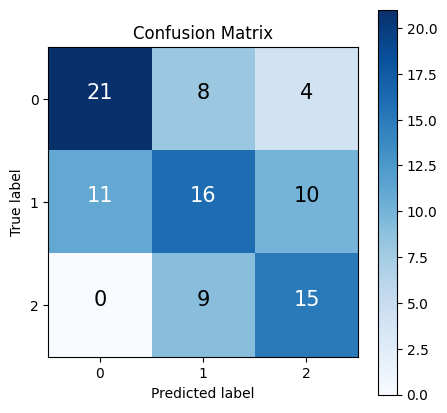

In [124]:
y_true = y_labels_test
y_pred = GBClass.predict(early_test_features)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

### Late Fusion

In [125]:
# Calcular predicciones train/val/test de classifier1D (datos tabulares)
late_DT_train = classificator1D.predict(X_train)
late_DT_valid = classificator1D.predict(X_valid)
late_DT_test  = classificator1D.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [126]:
print(late_DT_train.shape)
print(late_DT_valid.shape)
print(late_DT_test.shape)

(792, 3)
(88, 3)
(94, 3)


In [127]:
# Análogo para classificar imagenes , usaremos mobilenet_v2
late_images_train = model_mobilenet_v2.predict(images_train)
late_images_valid = model_mobilenet_v2.predict(images_valid)
late_images_test  = model_mobilenet_v2.predict(images_test)

3/3 [==============================] - 0s 35ms/step


In [128]:
print(late_images_train.shape)
print(late_images_valid.shape)
print(late_images_test.shape)

(792, 3)
(88, 3)
(94, 3)


In [129]:
late_train_features = np.concatenate((late_DT_train, late_images_train), axis=1)
late_valid_features = np.concatenate((late_DT_valid, late_images_valid)  , axis=1)
late_test_features  = np.concatenate((late_DT_test,  late_images_test) , axis=1)

y_labels_train = np.concatenate((y_train_multiclass, y_valid_multiclass))
y_labels_test = y_test_multiclass


#### SVC

In [130]:
late_fuser = SVC(random_state=420)
late_fuser.fit(X=np.concatenate((late_train_features, late_valid_features)),y=y_labels_train)
acc_late = late_fuser.score(X=late_test_features, y=y_labels_test)
print(f"Late fusion SVC {round(acc_late*100,2)} % accuracy")

Late fusion SVC 60.64 % accuracy


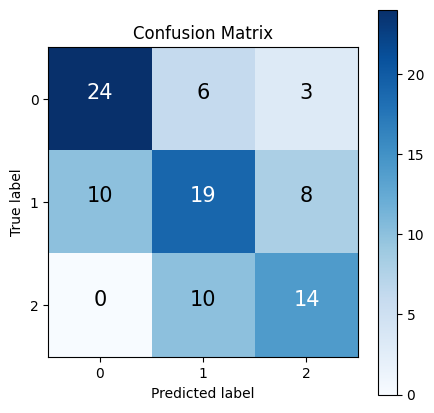

In [131]:
y_true = y_labels_test
y_pred = late_fuser.predict(late_test_features)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

#### GradientBoostingClassifier

In [132]:
GBClass = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0).fit(X=np.concatenate((late_train_features, late_valid_features)),y=y_labels_train)
acc_GBClass_late = GBClass.score(X=late_test_features, y=y_labels_test)
print(f"Early fusion GradientBoostingClassifier {round(acc_GBClass_late*100,2)}% accuracy")

Early fusion GradientBoostingClassifier 55.32% accuracy


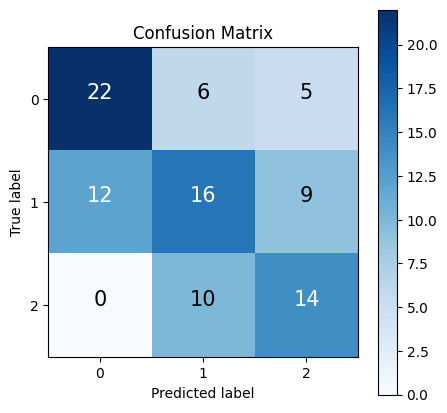

In [133]:
y_true = y_labels_test
y_pred = GBClass.predict(late_test_features)
make_confusion_matrix(y_true,y_pred,figsize=(5,5))

# 5. Conclusión

En esta práctica se ha realizado todos los pasos para realizar deep learning:

*   Descarga de datos
*   Análisis exploratorio
*   Preprocesamiento
*   Modelados con datos tabulares e imágenes
*   Transfer learning
*   Combinación de datos tabulares e imágenes para realizar early-Fusion y late-fusion

Los resultados en los datos tabulares son aceptables pero en las imágenes no han sido tan buenos dado sobre todo por la calidad de los datos.